In [158]:
import os

from pymatgen.io.vasp.inputs import Structure
import numpy as np
import pandas as pd
#import r2score from sklearn.metrics
from sklearn.metrics import r2_score

from qubitPack.tool_box import get_db

from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook'])
zfs_db = get_db("qubit_sensor", "tri_strained", port=27017, user="Jeng")


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/atomate/atomate/utils/database.py:51: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if self.db.counter.find({"_id": "taskid"}).count() == 0:


In [159]:
def get_st(st, bottom=24, NN=None):
    data = []
    for st in [st]:
        if not NN:
            NN = e["NN"]
        d = dict(
            zip(
                ["d1", "d2", "d3", "d4", "z1", "z2", "z3", "z4", "a", "b", "c", "NN", "spg"],
                np.array(
                    [st.get_distance(NN[-1], x) for x in NN[:-1]+[bottom] ]+
                    [st.sites[NN[-1]].coords[-1] - st.sites[x].coords[-1] for x in NN[:-1]+[bottom]]+
                    [st.lattice.a/5, st.lattice.b/5, st.lattice.c]+
                    [NN]+
                    [st.get_space_group_info()[0]]
                )))
        data.append(d)
    return data

# Strained ZFS & structure

In [265]:
Ds = []
es = zfs_db.collection.find({"task_label": "pyzfs"})
for e in es:
    taskid = e["task_id"]
    print(taskid)
    prev_fw_taskid = e["prev_fw_taskid"]
    scf_entry = zfs_db.collection.find_one({"task_id": prev_fw_taskid})
    data = {}
    formula = "".join(e["formula"].split(" "))
    D = e["pyzfs_out"]["D"]/1000
    E = e["pyzfs_out"]["E"]/1000
    strain_ratio = scf_entry["strain_ratio"]
    strain_comp = scf_entry["strain_component"] if "strain_component" in scf_entry else "xx_yy"
    if strain_ratio == 0:
        strain_comp ="pristine"
    data.update({"taskid": taskid, "formula": formula, "D": D, "E":E, "strain_ratio": strain_ratio, "strain_comp": strain_comp,
        "db_info": f"{zfs_db.db_name}.{zfs_db.collection.name}", "scf_taskid": prev_fw_taskid})
    Ds.append(data)
zfs_df = pd.DataFrame(Ds).sort_values("strain_ratio")

# only include those with strain_ratio from -0.08 to 0.08
zfs_df = zfs_df.loc[(zfs_df.strain_ratio >= -0.008) & (zfs_df.strain_ratio <= 0.008)]
display(zfs_df.round(2))

164
165
166
169
171
177
178
180
181
182
183
184
185
193
197
198
199
201
203
207
209
250
251
252
253
254
255
256
257
360
361
362
363
365
368
370
376
384
385
386
387
388
389
390
391
400
401
402
403
404
405
406
407
408
409
410
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
479
482


,taskid,formula,D,E,strain_ratio,strain_comp,db_info,scf_taskid
75,475,Mo26Se49,7.14,-0.00,-0.01,xx_yy,qubit_sensor.tri_strained,450
62,462,W26S49,8.15,-0.00,-0.01,xx_yy,qubit_sensor.tri_strained,430
28,257,Mo26S49,7.65,-0.38,-0.01,xx,qubit_sensor.tri_strained,235
43,390,W26Se49,5.91,-0.90,-0.01,xx,qubit_sensor.tri_strained,357
36,376,W26S49,6.62,-1.18,-0.01,xx,qubit_sensor.tri_strained,336
...,...,...,...,...,...,...,...,...
39,386,W26Se49,5.48,-0.97,0.01,xx,qubit_sensor.tri_strained,303
45,400,Mo26Se49,6.27,-0.39,0.01,xx,qubit_sensor.tri_strained,314
21,250,Mo26S49,7.41,-0.34,0.01,xx,qubit_sensor.tri_strained,246
18,203,Mo26S49,8.29,-0.00,0.01,xx_yy,qubit_sensor.tri_strained,202


In [266]:
zfs_df.loc[zfs_df.formula == "Mo26S49", ["strain_ratio", "strain_comp", "D", "E", "taskid",]]

,strain_ratio,strain_comp,D,E,taskid
28,-0.008,xx,7.647066,-0.375106,257
16,-0.008,xx_yy,8.477983,-0.000084,199
27,-0.006,xx,7.725000,-0.351118,256
13,-0.006,xx_yy,8.459152,-0.000575,193
26,-0.004,xx,7.843290,-0.322630,255
14,-0.004,xx_yy,8.442682,-0.000270,197
25,-0.002,xx,8.228726,-0.178015,254
17,-0.002,xx_yy,8.424827,-0.000456,201
12,0.000,pristine,8.409775,-0.000379,185
24,0.002,xx,8.120853,-0.183474,253


In [267]:
st_df = []
es = zfs_db.collection.find({"task_label": "pyzfs"})
for e in es:
    prev_fw_taskid = e["prev_fw_taskid"]
    scf_entry = zfs_db.collection.find_one({"task_id": prev_fw_taskid})
    st = Structure.from_dict(scf_entry["output"]["structure"])
    formula = scf_entry["formula_pretty"]
    if "Te" in formula:
        bottom = 50
        nn = scf_entry["NN"] #[54, 49, 55, 74]
    else:
        bottom = 50
        nn = scf_entry["NN"] #[5, 6, 0, 25]

    st0 = get_st(st, bottom=bottom, NN=nn)
    st0[0].update(
        {
            "taskid": e["task_id"],
            "formula": formula,
            "strain_ratio": scf_entry["strain_ratio"],
            "structure": st
        }
    )
    st_df.extend(st0)
st_df = pd.DataFrame(st_df)
display(st_df.round(2))

/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/pymatgen/core/lattice.py:1364: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,NN,spg,taskid,formula,strain_ratio,structure
0,2.67,2.67,2.67,3.52,1.97,1.97,1.97,3.52,3.18,3.18,23.09,"[5, 6, 0, 25]",P3m1,164,Mo26S49,0.01,"[[ 0.02679372 0.01546936 11.42993435] Mo, [14..."
1,2.66,2.66,2.66,3.57,2.00,2.00,2.00,3.57,3.12,3.12,23.09,"[5, 6, 0, 25]",P3m1,165,Mo26S49,-0.01,"[[ 0.02906705 0.01678186 11.41571072] Mo, [-1..."
2,2.66,2.66,2.66,3.60,2.01,2.01,2.01,3.60,3.08,3.08,23.09,"[5, 6, 0, 25]",P3m1,166,Mo26S49,-0.02,"[[ 0.02875031 0.016599 11.41303225] Mo, [-1..."
3,2.67,2.67,2.67,3.49,1.96,1.96,1.96,3.49,3.21,3.21,23.09,"[5, 6, 0, 25]",P3m1,169,Mo26S49,0.02,"[[ 0.0250689 0.0144828 11.42723279] Mo, [14..."
4,2.69,2.69,2.69,3.39,1.91,1.91,1.91,3.39,3.30,3.30,23.09,"[5, 6, 0, 25]",P3m1,171,Mo26S49,0.05,[[9.33451604e-03 5.37974634e-03 1.14457974e+01...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2.65,2.65,2.65,3.65,1.94,1.94,1.94,3.65,3.25,3.25,23.30,"[5, 6, 0, 25]",P3m1,475,Mo26Se49,-0.01,"[[ 0.05448621 0.03145763 11.53371291] Mo, [14..."
76,2.61,2.61,2.61,3.57,1.85,1.85,1.85,3.57,3.30,3.30,23.31,"[5, 6, 0, 25]",P3m1,476,W26Se49,0.01,"[[ 0.05333008 0.0307806 11.57135323] W, [14...."
77,2.63,2.63,2.63,3.49,1.92,1.92,1.92,3.49,3.17,3.17,23.11,"[5, 6, 0, 25]",P3m1,477,W26S49,0.01,"[[ 0.02370745 0.01369666 11.45998455] W, [14...."
78,2.61,2.61,2.61,3.58,1.86,1.86,1.86,3.58,3.29,3.29,23.31,"[5, 6, 0, 25]",P3m1,479,W26Se49,0.00,"[[ 0.05339798 0.03082934 11.56685421] W, [14...."


In [268]:
# combine zfs and structure by taskid
strained_df = zfs_df.merge(st_df, on="taskid")
# remove _y
strained_df = strained_df.loc[:, ~strained_df.columns.str.endswith("_y")]
# rename _x
strained_df = strained_df.rename(columns={x: x[:-2] for x in strained_df.columns if x.endswith("_x")})
display(strained_df.round(2))

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,scf_taskid,d1,d2,...,z1,z2,z3,z4,a,b,c,NN,spg,structure
0,475,Mo26Se49,7.14,-0.00,-0.01,xx_yy,qubit_sensor.tri_strained,450,2.65,2.65,...,1.94,1.94,1.94,3.65,3.25,3.25,23.30,"[5, 6, 0, 25]",P3m1,"[[ 0.05448621 0.03145763 11.53371291] Mo, [14..."
1,462,W26S49,8.15,-0.00,-0.01,xx_yy,qubit_sensor.tri_strained,430,2.63,2.63,...,1.95,1.95,1.95,3.54,3.12,3.12,23.11,"[5, 6, 0, 25]",P3m1,"[[ 0.02582896 0.01491235 11.4445724 ] W, [14...."
2,257,Mo26S49,7.65,-0.38,-0.01,xx,qubit_sensor.tri_strained,235,2.60,2.67,...,2.01,1.98,1.97,3.56,3.12,3.15,23.09,"[0, 5, 6, 25]",P1,[[3.36809794e-02 3.92443488e-03 1.13889029e+01...
3,390,W26Se49,5.91,-0.90,-0.01,xx,qubit_sensor.tri_strained,357,2.54,2.61,...,1.91,1.86,1.84,3.59,3.25,3.28,23.31,"[0, 5, 6, 25]",P1,[[4.85089963e-02 7.54543314e-03 1.15118403e+01...
4,376,W26S49,6.62,-1.18,-0.01,xx,qubit_sensor.tri_strained,336,2.54,2.67,...,2.00,1.91,1.91,3.53,3.12,3.15,23.11,"[0, 5, 6, 25]",P1,"[[-7.85062621 13.62447877 11.37994304] W, [-1...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,386,W26Se49,5.48,-0.97,0.01,xx,qubit_sensor.tri_strained,303,2.53,2.63,...,1.89,1.83,1.82,3.56,3.30,3.28,23.31,"[6, 5, 0, 25]",P1,"[[ 0.03364642 0.03985464 11.58536312] W, [14...."
64,400,Mo26Se49,6.27,-0.39,0.01,xx,qubit_sensor.tri_strained,314,2.56,2.67,...,1.94,1.90,1.89,3.61,3.30,3.28,23.30,"[6, 5, 0, 25]",P1,"[[ 0.03810517 0.04234327 11.55682619] Mo, [14..."
65,250,Mo26S49,7.41,-0.34,0.01,xx,qubit_sensor.tri_strained,246,2.59,2.68,...,2.00,1.97,1.96,3.54,3.17,3.15,23.09,"[6, 5, 0, 25]",P1,"[[ 0.01800881 0.02388727 11.4376927 ] Mo, [14..."
66,203,Mo26S49,8.29,-0.00,0.01,xx_yy,qubit_sensor.tri_strained,202,2.67,2.67,...,1.97,1.97,1.97,3.53,3.17,3.17,23.09,"[5, 6, 0, 25]",P3m1,"[[ 0.02754161 0.015892 11.42704806] Mo, [14..."


## Add dD and dE

In [269]:
# update strained_ratio for those with strain_ratio == -1 by calculating the ratio of the difference bewteen their a
# and the pristine a (strain_ratio == 0)
df = strained_df.copy()

#add dD = D(strain_ratio) - D(0)
df.loc[df["strain_ratio"] != 0, "dD"] = df.loc[df["strain_ratio"] != 0, "D"] - df.loc[df["strain_ratio"] == 0, "D"].iloc[0]
# if NaN, set to 0
df["dD"] = df["dD"].fillna(0)

#add dE = E(strain_ratio) - E(0)
df.loc[df["strain_ratio"] != 0, "dE"] = df.loc[df["strain_ratio"] != 0, "E"] - df.loc[df["strain_ratio"] == 0, "E"].iloc[0]
# if NaN, set to 0
df["dE"] = df["dE"].fillna(0)

# df["dD_ratio"] = df["dD_ratio"]


In [192]:
df.loc[df.strain_comp=="pristine"]

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,scf_taskid,d1,d2,...,z3,z4,a,b,c,NN,spg,structure,dD,dE
38,185,Mo26S49,8.409775,-0.000379,0.0,pristine,qubit_sensor.tri_strained,159,2.667285,2.667275,...,1.983689,3.550666,3.146908,3.146908,23.090310,"[5, 6, 0, 25]",P3m1,"[[ 0.02926624 0.01689687 11.41755795] Mo, [14...",0.0,0.0
39,361,Mo26Se49,7.217472,-0.001006,0.0,pristine,qubit_sensor.tri_strained,285,2.654879,2.654879,...,1.925346,3.632932,3.278162,3.278162,23.299677,"[5, 6, 0, 25]",P3m1,"[[ 0.0560156 0.03235009 11.53261783] Mo, [14...",0.0,0.0
40,360,W26Se49,6.770499,-0.000285,0.0,pristine,qubit_sensor.tri_strained,286,2.614874,2.614864,...,1.868164,3.596742,3.275457,3.275457,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05323437 0.03073488 11.56391703] W, [14....",0.0,0.0
41,365,W26S49,7.888439,-0.000395,0.0,pristine,qubit_sensor.tri_strained,277,2.632206,2.632187,...,1.931579,3.516419,3.147447,3.147446,23.106671,"[5, 6, 0, 25]",P3m1,"[[ 0.02515597 0.01451471 11.44854675] W, [14....",0.0,0.0


In [205]:
df.loc[(df.formula == "Mo26Se49")&(df.strain_comp=="xx_yy"), ["strain_ratio", "strain_comp", "D", "E", "dD", "dE", "taskid", 'a', 'b', "scf_taskid"]]

,strain_ratio,strain_comp,D,E,dD,dE,taskid,a,b,scf_taskid
6,-0.008,xx_yy,7.142821,-0.000979,-1.266954,-0.000600,475,3.251937,3.251937,450
18,-0.006,xx_yy,7.151433,-0.001592,-1.258341,-0.001214,474,3.258493,3.258493,454
28,-0.004,xx_yy,7.156046,-0.001345,-1.253729,-0.000966,473,3.265049,3.265049,455
36,-0.002,xx_yy,7.178795,-0.001005,-1.230980,-0.000627,472,3.271606,3.271605,451
49,0.002,xx_yy,7.260965,-0.001203,-1.148809,-0.000825,471,3.284718,3.284718,445
56,0.004,xx_yy,7.316051,-0.001356,-1.093723,-0.000977,470,3.291275,3.291274,447
65,0.006,xx_yy,7.323046,-0.001217,-1.086729,-0.000839,482,3.297831,3.297831,481
66,0.008,xx_yy,7.278225,-0.001291,-1.131550,-0.000912,469,3.304387,3.304387,446


## Separate df into different strain components

In [270]:
for strain_comp, d in df.groupby("strain_comp"):
    # claim a new df for each strain component
    print(strain_comp)
    if strain_comp == "pristine":
        continue
    exec(f"{strain_comp}_df = d")
    # add the row with strain_ratio == 0 to each df
    exec(f"{strain_comp}_df = {strain_comp}_df.append(df.loc[df.strain_ratio==0])")
    # sort by strain_ratio
    exec(f"{strain_comp}_df = {strain_comp}_df.sort_values('strain_ratio')")

pristine
xx
xx_yy


# ZFS plotting

## D & Structural info

In [177]:
def plot_D_structure(plot_df, xrange_setting=None):
    for plt_idx, formula in enumerate(plot_df.sort_values(by="formula")["formula"].unique()):
        if "Te" in formula:
            continue
        fig = plt.figure(figsize=(10, 8))
        print(formula)
        zfs_all = plot_df.loc[(df["formula"] == formula)].sort_values("strain_ratio")
        xrange_setting = xrange_setting or {}
        xrange_min =  xrange_setting.get("xrange_min", -0.06)
        xrange_max = xrange_setting.get("xrange_max", 0.06)
        xrange_step = xrange_setting.get("xrange_step", 0.02)
        xrange_list = np.arange(xrange_min, xrange_max+xrange_step, xrange_step)
        # pair the xrange_list
        xrange_list = xrange_setting.get("xrange_list", list(zip(xrange_list[:-1], xrange_list[1:])))
        print(f"xrange_list: {xrange_list}")

    ############################3
        ax = fig.add_subplot(2, 2, 2)
        d2_sub_d3 = zfs_all["d2"] - zfs_all["d3"]

        ax.set_ylabel("distance (Å)")
        ax.plot(zfs_all["strain_ratio"], np.abs(d2_sub_d3), "o:", label="|d2-d3|")
        ax.plot(zfs_all["strain_ratio"], d2_sub_d3, "o:", label="d2-d3")
        ax.set_xlabel("Strain ratio")
        ax.set_title("|d2-d3|")
        ax.legend(fancybox=False, edgecolor="black")

        # plot curve fitting
        # strain_ratios = np.linspace(-0.06, 0.06, 100)
        # z1_fit = np.poly1d(np.polyfit(zfs_all["strain_ratio"], d2_sub_d3, 1))
        # ax.plot(strain_ratios, z1_fit(strain_ratios), "-", label="z fit")
        # # add fitting formula as text at the bottom left corner
        # ax.text(0.05, 0.05, r"$z = %.2f x + %.2f$" % tuple(z1_fit.coeffs),
        #         transform=ax.transAxes, fontsize=12, verticalalignment="bottom", bbox=dict(facecolor='white', alpha=0.5))

    ######################################3
        ax = fig.add_subplot(2, 2, 4)
        a_sub_b = zfs_all["a"] - zfs_all["b"]
        ax.set_ylabel("Lattice const. (Å)")
        ax.plot(zfs_all["strain_ratio"], np.abs(a_sub_b), "o:", label="|a-b|")

        ax.set_xlabel("Strain ratio")
        ax.set_title(f"|a-b|")
        ax.legend(fancybox=False, edgecolor="black")


    ###########################################3
        ax= fig.add_subplot(2, 2, 1)
        for idx, x_range in enumerate(xrange_list):
            zfs = zfs_all.loc[(zfs_all["strain_ratio"]>=x_range[0]) & (zfs_all["strain_ratio"]<=x_range[1])]
            # fit with linear function and plot
            strain_ratios = np.linspace(x_range[0], x_range[1], 100)
            Ds = zfs["dD"].values
            print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Ds: {len(Ds)}, xrange: {x_range}, strain_ratios: "
                  f"{zfs.strain_ratio.values}")
            D_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Ds, 1))
            r2 = r2_score(zfs["dD"], D_fit(zfs["strain_ratio"]))
            slope = D_fit.coeffs[0].__round__(1)
            ax.plot(zfs["strain_ratio"], zfs["dD"], "o:")
            ax.plot(strain_ratios, D_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
            ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

            ax.set_ylabel("dD (GHz)")
            ax.set_xlabel("Strain ratio")
            ax.set_title(formula)


        ax = fig.add_subplot(2, 2, 3)
        for idx, x_range in enumerate(xrange_list):
            zfs = zfs_all.loc[(zfs_all["strain_ratio"]>=x_range[0]) & (zfs_all["strain_ratio"]<=x_range[1])]
            # fit with linear function and plot
            # strain_ratios = np.linspace(x_range[0], x_range[1], 100)
            # Es = zfs["dE"].values
            # print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Es: {len(Es)}, xrange: {x_range}")
            # E_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Es, 1))
            # r2 = r2_score(zfs["dE"], E_fit(zfs["strain_ratio"]))
            # slope = E_fit.coeffs[0].__round__(1)
            ax.plot(zfs["strain_ratio"], zfs["dE"], "o:")
            # ax.plot(strain_ratios, E_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
            ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
            #
            ax.set_ylabel("dE (GHz)")
            ax.set_xlabel("Strain ratio")
            ax.set_title(formula)


        fig.tight_layout()
        return fig




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mo26S49
xrange_list: [(-0.06, -0.04), (-0.03, -0.01), (-0.008, 0.008), (0.01, 0.06)]
zfs_strain_ratio: 3, Ds: 3, xrange: (-0.06, -0.04), strain_ratios: [-0.06 -0.05 -0.04]
zfs_strain_ratio: 3, Ds: 3, xrange: (-0.03, -0.01), strain_ratios: [-0.03 -0.02 -0.01]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 6, Ds: 6, xrange: (0.01, 0.06), strain_ratios: [0.01 0.02 0.03 0.04 0.05 0.06]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == "__main__":


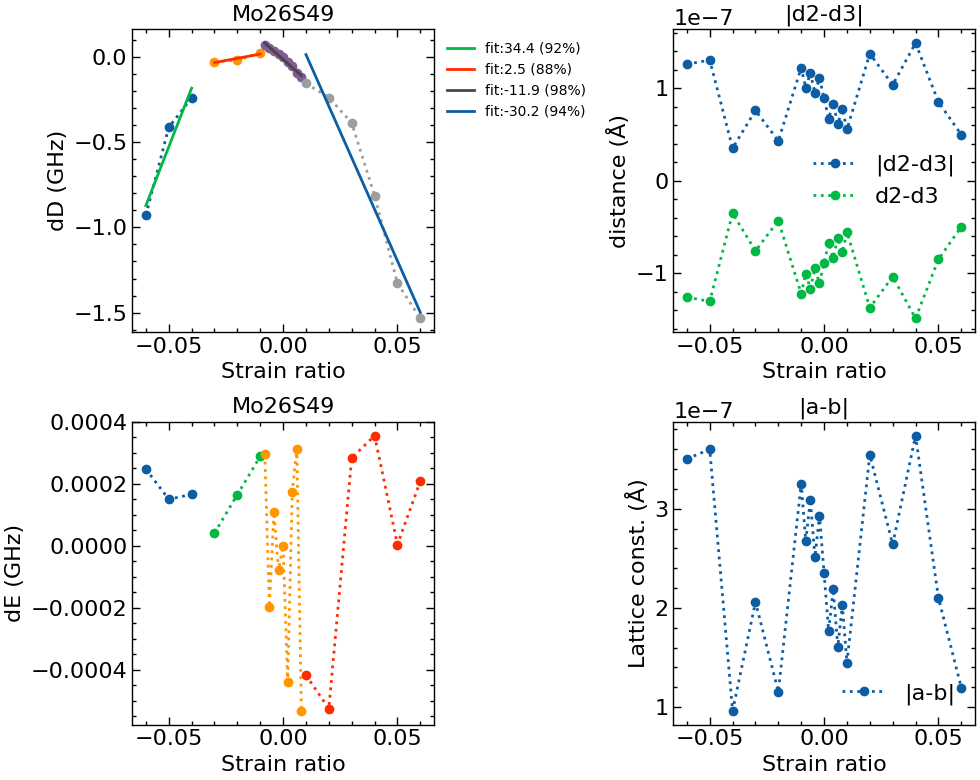

In [178]:
fig = plot_D_structure(xx_yy_df, xrange_setting={"xrange_list": [(-0.06, -0.04), (-0.03, -0.01), (-0.008, 0.008),
                                                                 (0.01, 0.06)]})

# fig = plot_D_structure(xx_yy_df, xrange_setting={"xrange_list": [ (-0.03, -0.0095), (-0.0095, 0.008),]})

# fig = plot_D_structure(xx_yy_df, xrange_setting={"xrange_list": [(-0.008, 0.008),]})

# fig = plot_D_structure(xx_yy_df, xrange_setting={"xrange_list": [(-0.008, 0.02),]})
fig.show()

## Mutiple defects

### xx_yy_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mo26S49
xrange_list: [(-0.008, 0.008)]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
Mo26Se49
xrange_list: [(-0.008, 0.008)]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


W26S49
xrange_list: [(-0.008, 0.008)]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
W26Se49
xrange_list: [(-0.008, 0.008)]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



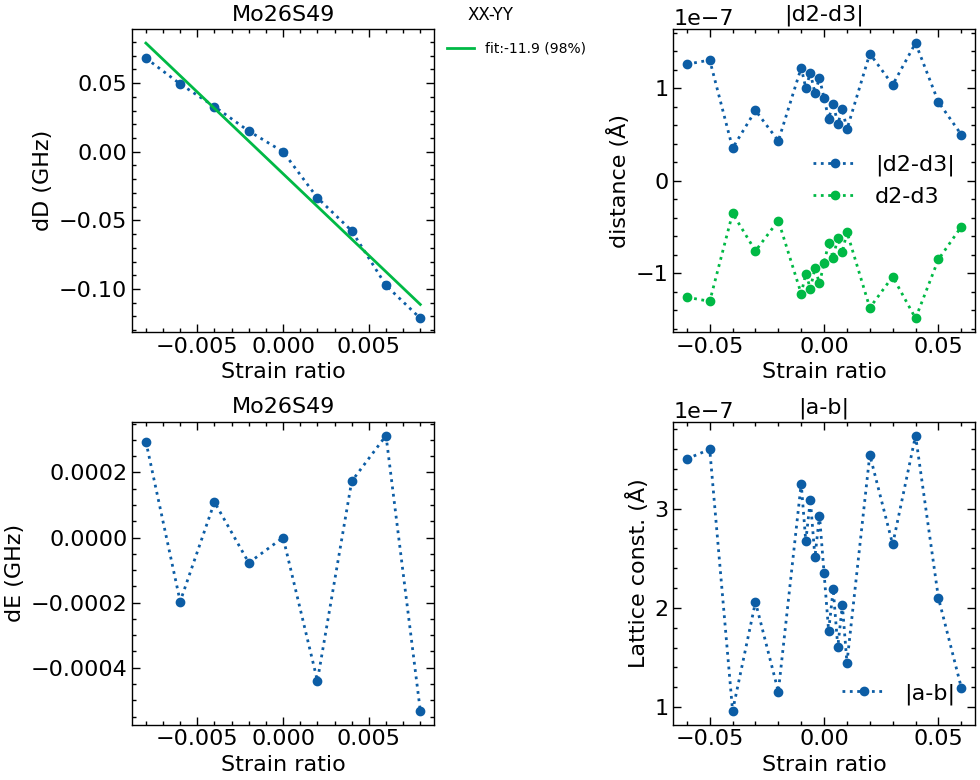

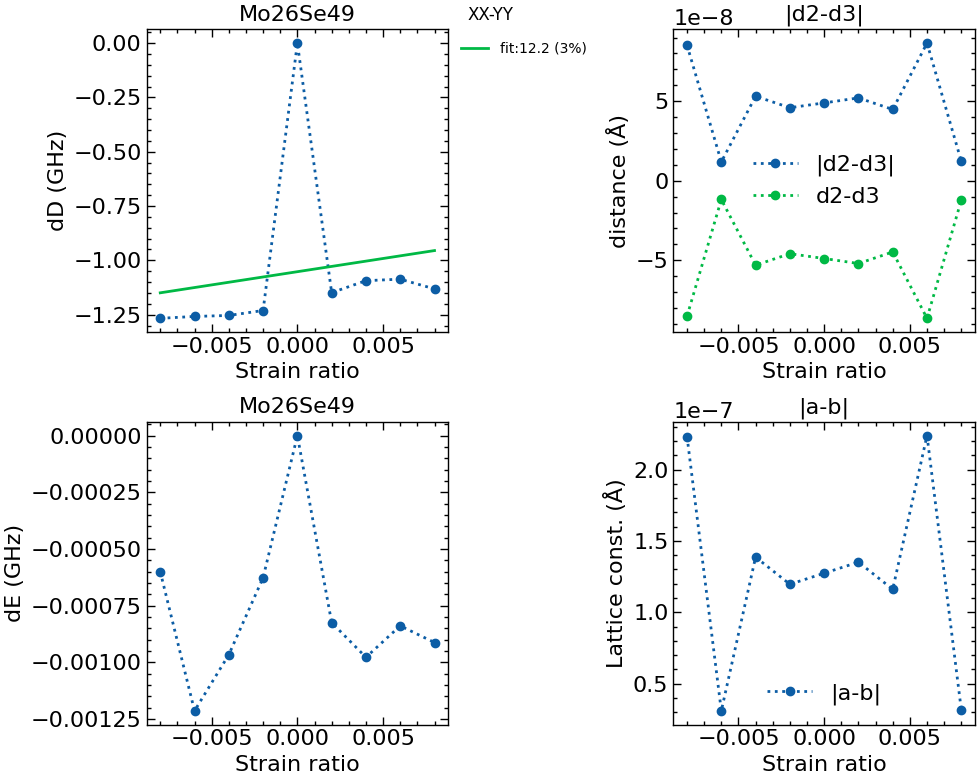

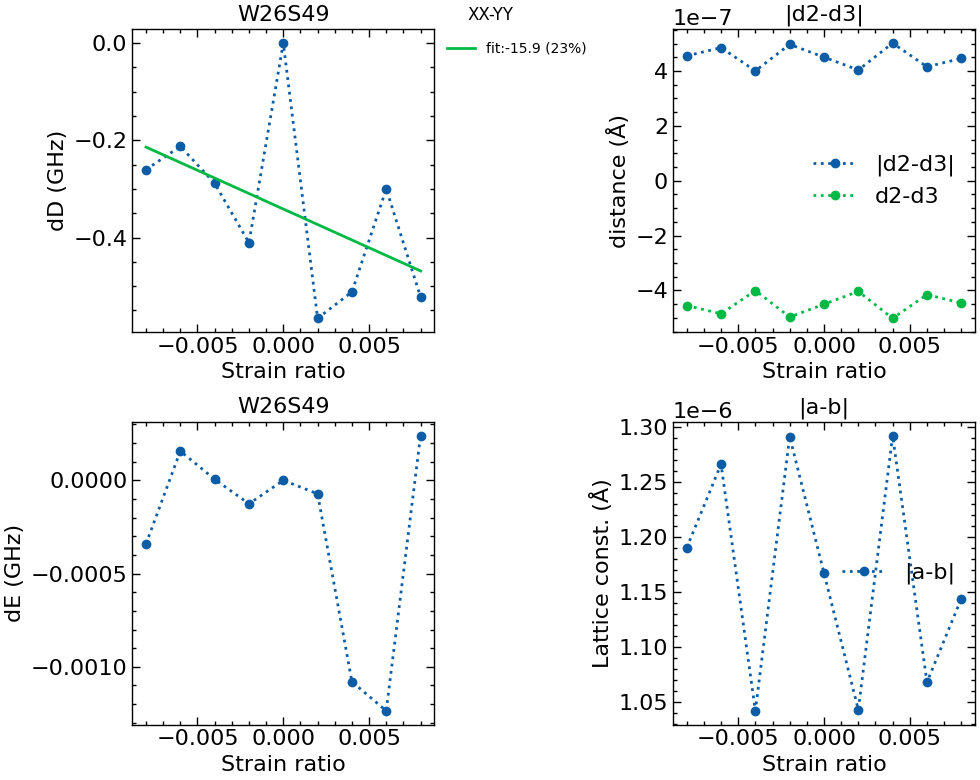

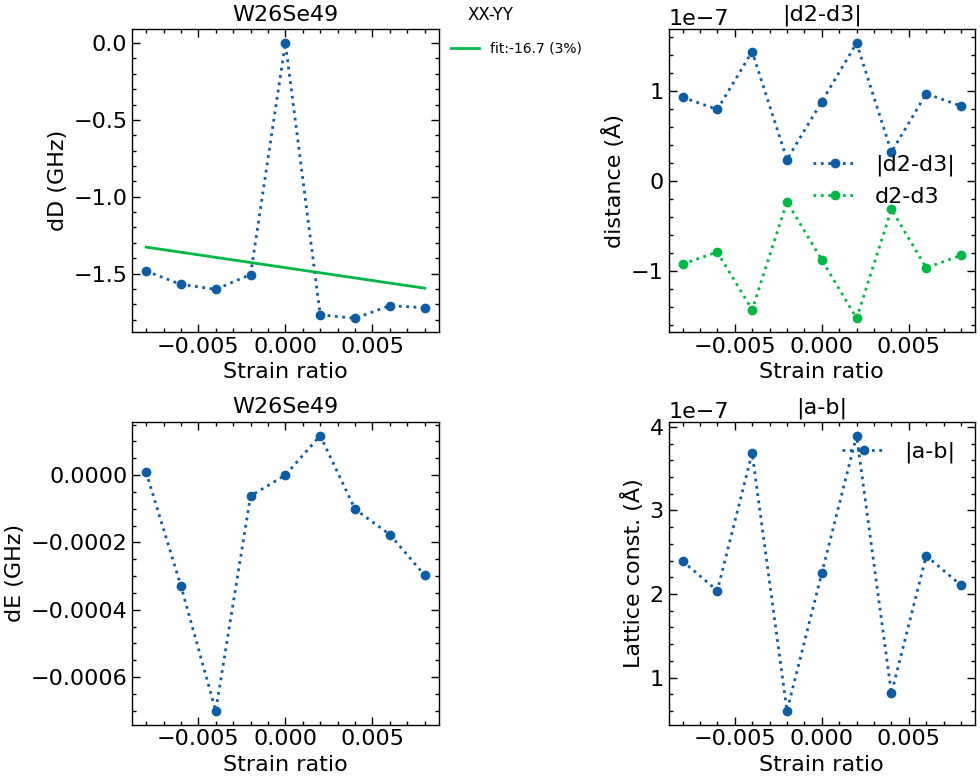

In [222]:
for chem in xx_yy_df.loc[:, "formula"].unique():
    xx_yy_chem_df = xx_yy_df.loc[xx_yy_df.formula==chem]
    fig = plot_D_structure(xx_yy_chem_df, xrange_setting={"xrange_list": [(-0.008, 0.008),]})
    #add fig title
    fig.suptitle("XX-YY")
    fig.show()

#### dD

zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


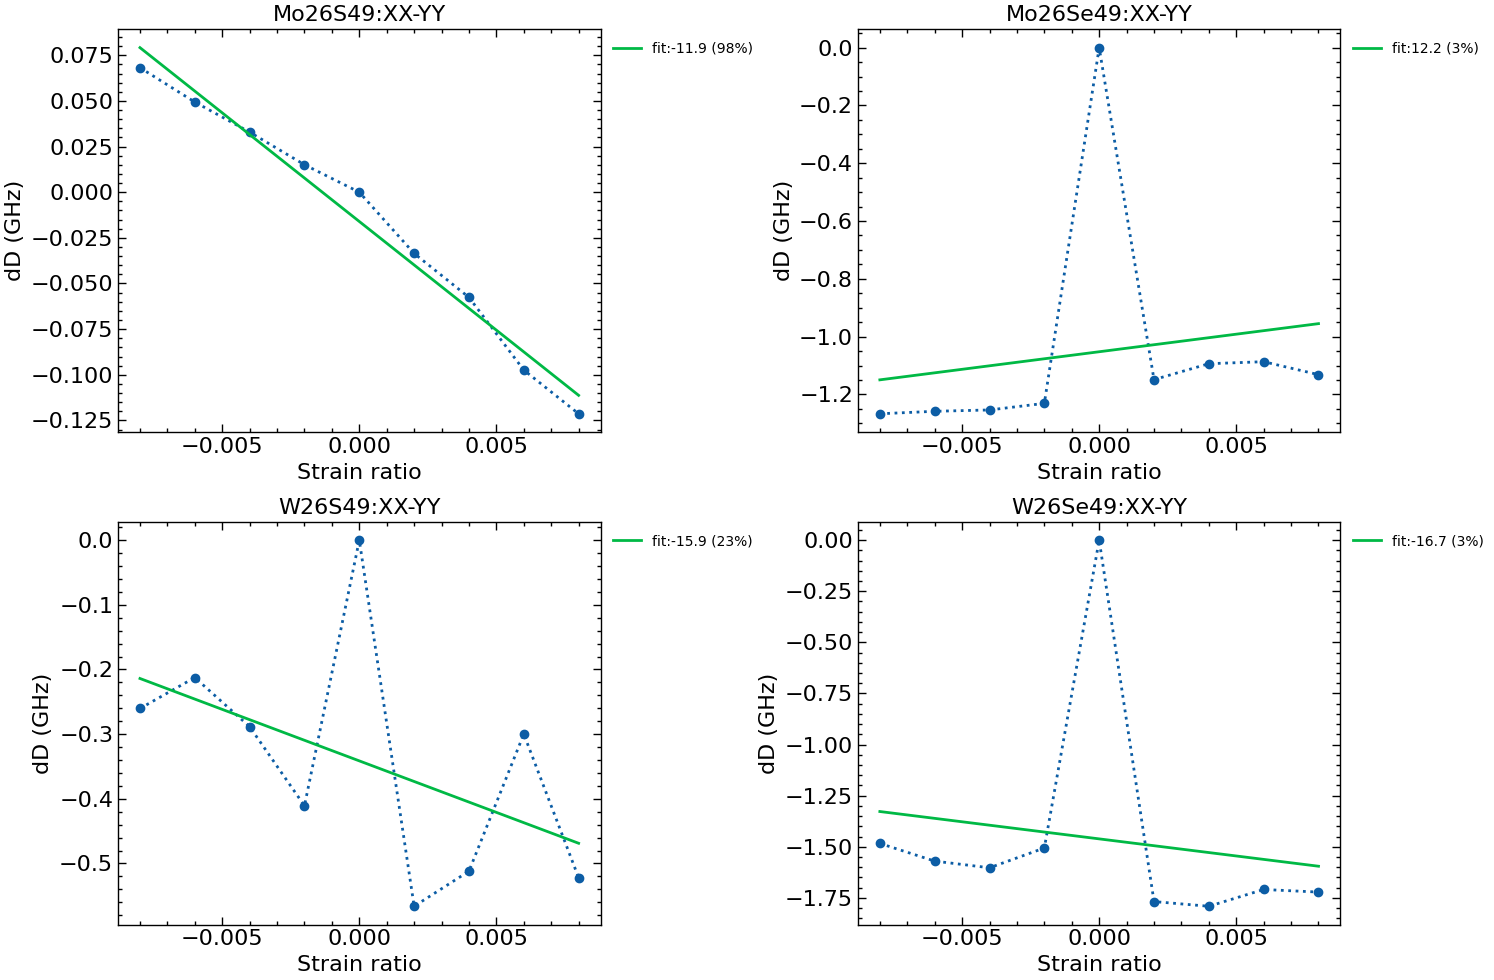

In [181]:
# extract the first subplot for each chem and put them together in one figure for comparison
# make a figure more wide than high
fig = plt.figure(figsize=(15, 10))
for idx, chem in enumerate(xx_yy_df.loc[:, "formula"].unique()):
    xx_yy_chem_df = xx_yy_df.loc[xx_yy_df.formula==chem]
    ax = fig.add_subplot(2, 2, idx+1)
    for idx, x_range in enumerate([(-0.008, 0.008),]):
        zfs = xx_yy_chem_df.loc[(xx_yy_chem_df["strain_ratio"]>=x_range[0]) & (xx_yy_chem_df["strain_ratio"]<=x_range[1])]
        # fit with linear function and plot
        strain_ratios = np.linspace(x_range[0], x_range[1], 100)
        Ds = zfs["dD"].values
        print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Ds: {len(Ds)}, xrange: {x_range}, strain_ratios: "
              f"{zfs.strain_ratio.values}")
        D_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Ds, 1))
        r2 = r2_score(zfs["dD"], D_fit(zfs["strain_ratio"]))
        slope = D_fit.coeffs[0].__round__(1)
        ax.plot(zfs["strain_ratio"], zfs["dD"], "o:")
        ax.plot(strain_ratios, D_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
        ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        ax.set_ylabel("dD (GHz)")
        ax.set_xlabel("Strain ratio")
        ax.set_title(chem+":XX-YY")

        # set y lim from 2 to -0.1
        # ax.set_ylim(-0.5, 2)
fig.tight_layout()
fig.show()


#### dE

zfs_strain_ratio: 9, Es: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 7, Es: 7, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.006]
zfs_strain_ratio: 8, Es: 8, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.008]
zfs_strain_ratio: 8, Es: 8, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


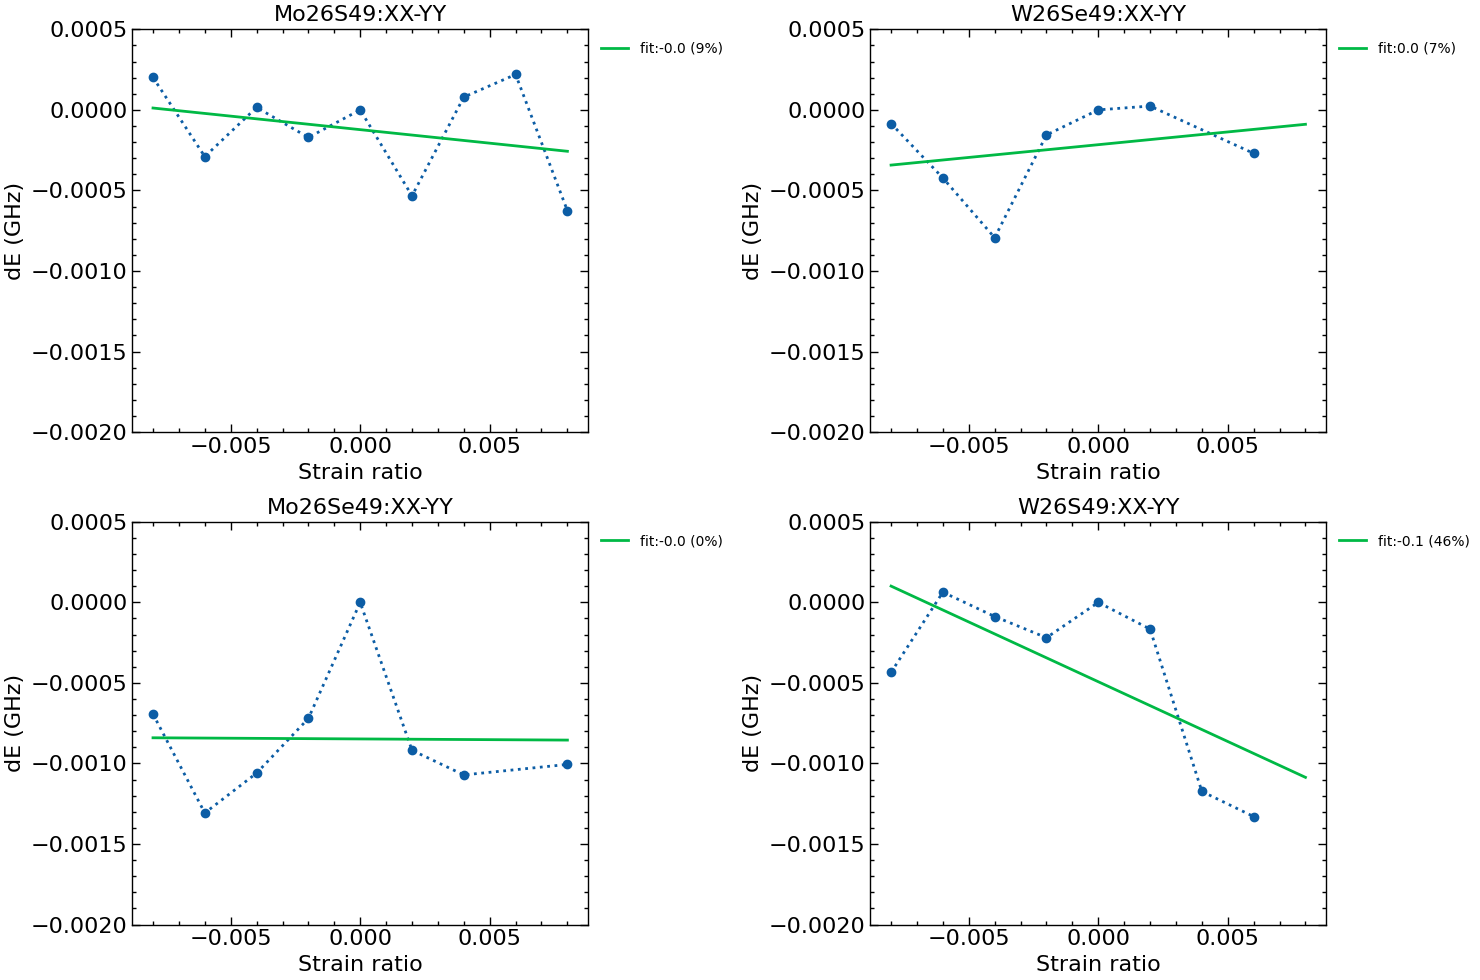

In [153]:
# plot dE vs strain ratio for each chem
# make a figure more wide than high
fig = plt.figure(figsize=(15, 10))
for idx, chem in enumerate(xx_yy_df.loc[:, "formula"].unique()):
    xx_yy_chem_df = xx_yy_df.loc[xx_yy_df.formula==chem]
    ax = fig.add_subplot(2, 2, idx+1)
    for idx, x_range in enumerate([(-0.008, 0.008),]):
        zfs = xx_yy_chem_df.loc[(xx_yy_chem_df["strain_ratio"]>=x_range[0]) & (xx_yy_chem_df["strain_ratio"]<=x_range[1])]
        # fit with linear function and plot
        strain_ratios = np.linspace(x_range[0], x_range[1], 100)
        Es = zfs["dE"].values
        print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Es: {len(Es)}, xrange: {x_range}, strain_ratios: "
              f"{zfs.strain_ratio.values}")
        E_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Es, 1))
        r2 = r2_score(zfs["dE"], E_fit(zfs["strain_ratio"]))
        slope = E_fit.coeffs[0].__round__(1)
        ax.plot(zfs["strain_ratio"], zfs["dE"], "o:")
        ax.plot(strain_ratios, E_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
        ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        ax.set_ylabel("dE (GHz)")
        ax.set_xlabel("Strain ratio")
        ax.set_title(chem+":XX-YY")

        # set y lim from 5e-4 to -20e-4
        ax.set_ylim(-20e-4, 5e-4)
fig.tight_layout()
fig.show()


#### d2

zfs_strain_ratio: 9, d2s: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, d2s: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, d2s: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, d2s: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



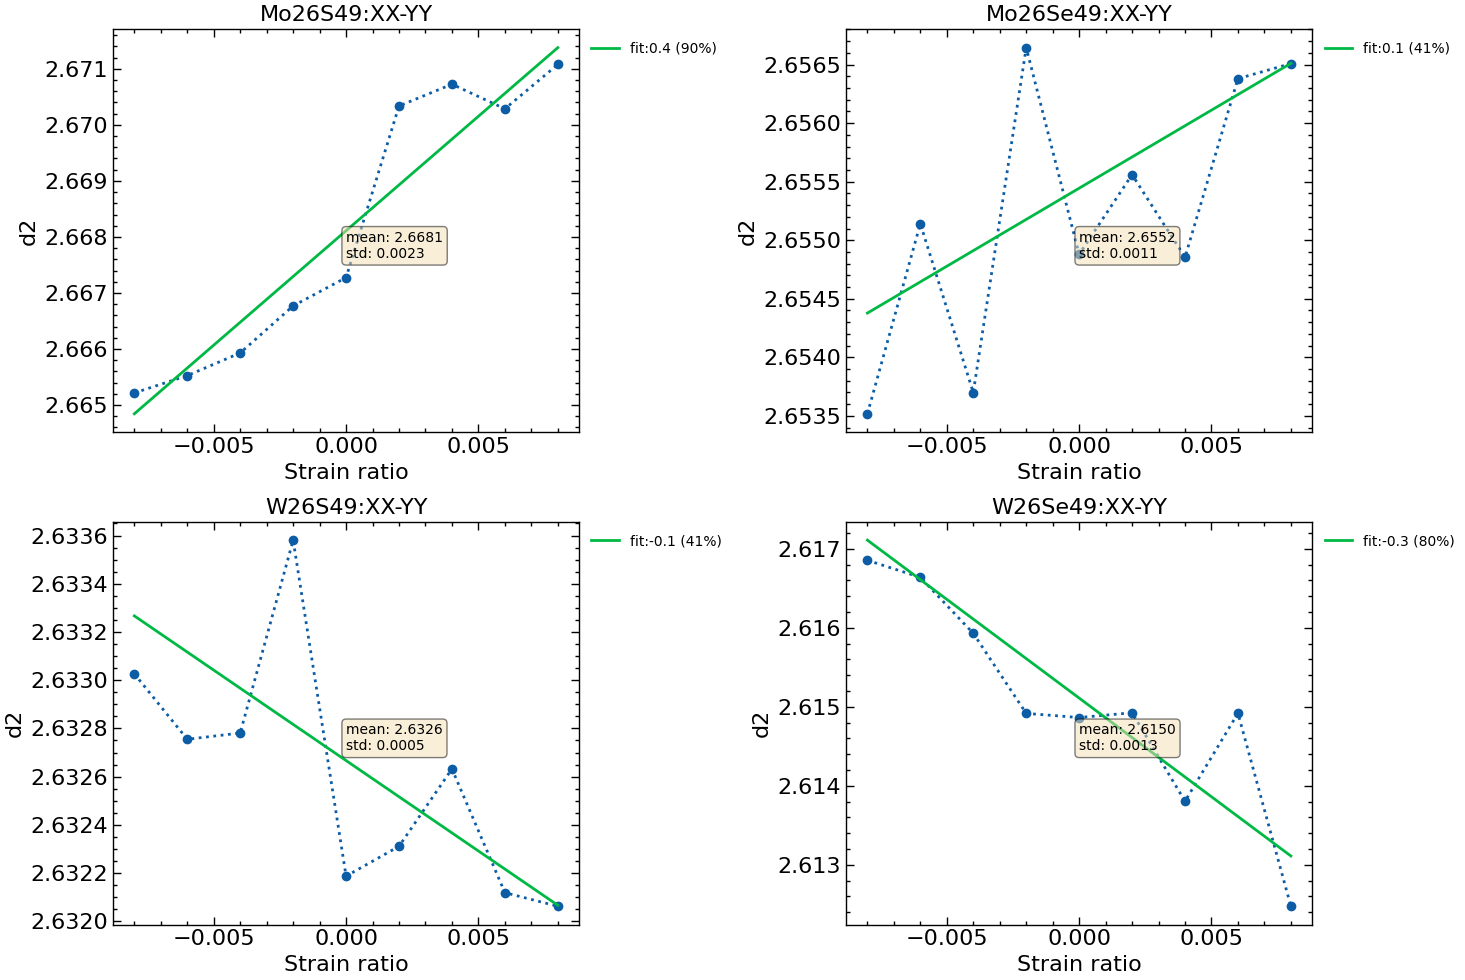

In [229]:
# plot d2 vs strain ratio for each chem
# make a figure more wide than high
fig = plt.figure(figsize=(15, 10))
for idx, chem in enumerate(xx_yy_df.loc[:, "formula"].unique()):
    xx_yy_chem_df = xx_yy_df.loc[xx_yy_df.formula==chem]
    ax = fig.add_subplot(2, 2, idx+1)
    for idx, x_range in enumerate([(-0.008, 0.008),]):
        zfs = xx_yy_chem_df.loc[(xx_yy_chem_df["strain_ratio"]>=x_range[0]) & (xx_yy_chem_df["strain_ratio"]<=x_range[1])]
        # fit with linear function and plot
        strain_ratios = np.linspace(x_range[0], x_range[1], 100)
        d2s = zfs["d2"].values
        # round d2 to 1e-3
        d2s = np.round(d2s, 3)
        print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, d2s: {len(d2s)}, xrange: {x_range}, strain_ratios: "
              f"{zfs.strain_ratio.values}")
        d2_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], d2s, 1))
        r2 = r2_score(zfs["d2"], d2_fit(zfs["strain_ratio"]))
        slope = d2_fit.coeffs[0].__round__(1)
        ax.plot(zfs["strain_ratio"], zfs["d2"], "o:")
        ax.plot(strain_ratios, d2_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
        ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        ax.set_ylabel("d2")
        ax.set_xlabel("Strain ratio")
        ax.set_title(chem+":XX-YY")

        # add mean and std of d2
        d2_mean = np.mean(zfs["d2"])
        d2_std = np.std(zfs["d2"])
        ax.text(0.5, 0.5, f"mean: {d2_mean:.4f}\nstd: {d2_std:.4f}", transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


        # set y lim from 5e-4 to -20e-4
        # ax.set_ylim(-20e-4, 5e-4)
        # round y ticks to 2 decimal places
        # from matplotlib.ticker import FormatStrFormatter
        # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.tight_layout()
fig.show()


### xx_df

In [361]:
xx_df

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,scf_taskid,d1,d2,...,z3,z4,a,b,c,NN,spg,structure,dD,dE
2,257,Mo26S49,7.647066,-0.375106,-0.008,xx,qubit_sensor.tri_strained,235,2.600404,2.670111,...,1.969373,3.556993,3.121733,3.146908,23.090310,"[0, 5, 6, 25]",P1,[[3.36809794e-02 3.92443488e-03 1.13889029e+01...,-0.762709,-0.374727
3,390,W26Se49,5.912539,-0.901465,-0.008,xx,qubit_sensor.tri_strained,357,2.541405,2.614163,...,1.838746,3.594947,3.249253,3.275457,23.310965,"[0, 5, 6, 25]",P1,[[4.85089963e-02 7.54543314e-03 1.15118403e+01...,-2.497236,-0.901086
4,376,W26S49,6.624615,-1.175936,-0.008,xx,qubit_sensor.tri_strained,336,2.536448,2.672073,...,1.908495,3.529983,3.122267,3.147446,23.106671,"[0, 5, 6, 25]",P1,"[[-7.85062621 13.62447877 11.37994304] W, [-1....",-1.785160,-1.175557
5,407,Mo26Se49,6.194830,-0.388001,-0.008,xx,qubit_sensor.tri_strained,305,2.574169,2.657539,...,1.907148,3.632816,3.251937,3.278162,23.299677,"[0, 5, 6, 25]",P1,"[[ 0.05913903 0.01176754 11.50337673] Mo, [-1...",-2.214944,-0.387622
8,256,Mo26S49,7.725000,-0.351118,-0.006,xx,qubit_sensor.tri_strained,245,2.599747,2.672833,...,1.966602,3.553275,3.128027,3.146908,23.090310,"[0, 5, 6, 25]",P1,[[3.37713899e-02 5.51873655e-03 1.13943522e+01...,-0.684774,-0.350739
13,385,W26Se49,5.950818,-0.880796,-0.006,xx,qubit_sensor.tri_strained,359,2.544448,2.611617,...,1.838349,3.593502,3.255804,3.275457,23.310965,"[0, 5, 6, 25]",P1,[[4.91531135e-02 9.80055319e-03 1.15137052e+01...,-2.458957,-0.880417
14,405,Mo26Se49,6.314925,-0.386219,-0.006,xx,qubit_sensor.tri_strained,307,2.571466,2.668414,...,1.907871,3.631255,3.258493,3.278162,23.299677,"[0, 5, 6, 25]",P1,"[[ 0.05758928 0.01778616 11.50498441] Mo, [-1...",-2.094849,-0.385841
15,363,W26S49,6.688097,-1.166174,-0.006,xx,qubit_sensor.tri_strained,329,2.539739,2.672866,...,1.906578,3.524437,3.128562,3.147446,23.106671,"[0, 5, 6, 25]",P1,"[[-7.85031996 13.62635955 11.38507272] W, [-1....",-1.721678,-1.165795
23,410,W26S49,6.651204,-1.201549,-0.004,xx,qubit_sensor.tri_strained,331,2.537443,2.676313,...,1.902742,3.519238,3.134857,3.147446,23.106671,"[0, 5, 6, 25]",P1,"[[-7.85221088 13.62841751 11.38352457] W, [-1....",-1.758571,-1.201170
18,391,W26Se49,5.695182,-1.073759,-0.004,xx,qubit_sensor.tri_strained,356,2.534113,2.647057,...,1.842219,3.587884,3.262355,3.275457,23.310965,"[0, 5, 6, 25]",P1,"[[ 0.04247692 0.01720415 11.51349541] W, [-1....",-2.714592,-1.073380


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


W26Se49
xrange_list: [(-0.008, -0.004), (-0.004, 0.004), (0.004, 0.008)]
zfs_strain_ratio: 3, Ds: 3, xrange: (-0.008, -0.004), strain_ratios: [-0.008 -0.006 -0.004]
zfs_strain_ratio: 5, Ds: 5, xrange: (-0.004, 0.004), strain_ratios: [-0.004 -0.002  0.     0.002  0.004]
zfs_strain_ratio: 3, Ds: 3, xrange: (0.004, 0.008), strain_ratios: [0.004 0.006 0.008]
Mo26S49
xrange_list: [(-0.008, -0.004), (-0.004, 0.004), (0.004, 0.008)]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


zfs_strain_ratio: 3, Ds: 3, xrange: (-0.008, -0.004), strain_ratios: [-0.008 -0.006 -0.004]
zfs_strain_ratio: 5, Ds: 5, xrange: (-0.004, 0.004), strain_ratios: [-0.004 -0.002  0.     0.002  0.004]
zfs_strain_ratio: 3, Ds: 3, xrange: (0.004, 0.008), strain_ratios: [0.004 0.006 0.008]
Mo26Se49
xrange_list: [(-0.008, -0.004), (-0.004, 0.004), (0.004, 0.008)]
zfs_strain_ratio: 3, Ds: 3, xrange: (-0.008, -0.004), strain_ratios: [-0.008 -0.006 -0.004]
zfs_strain_ratio: 5, Ds: 5, xrange: (-0.004, 0.004), strain_ratios: [-0.004 -0.002  0.     0.002  0.004]
zfs_strain_ratio: 3, Ds: 3, xrange: (0.004, 0.008), strain_ratios: [0.004 0.006 0.008]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with

W26S49
xrange_list: [(-0.008, -0.004), (-0.004, 0.004), (0.004, 0.008)]
zfs_strain_ratio: 3, Ds: 3, xrange: (-0.008, -0.004), strain_ratios: [-0.008 -0.006 -0.004]
zfs_strain_ratio: 5, Ds: 5, xrange: (-0.004, 0.004), strain_ratios: [-0.004 -0.002  0.     0.002  0.004]
zfs_strain_ratio: 3, Ds: 3, xrange: (0.004, 0.008), strain_ratios: [0.004 0.006 0.008]


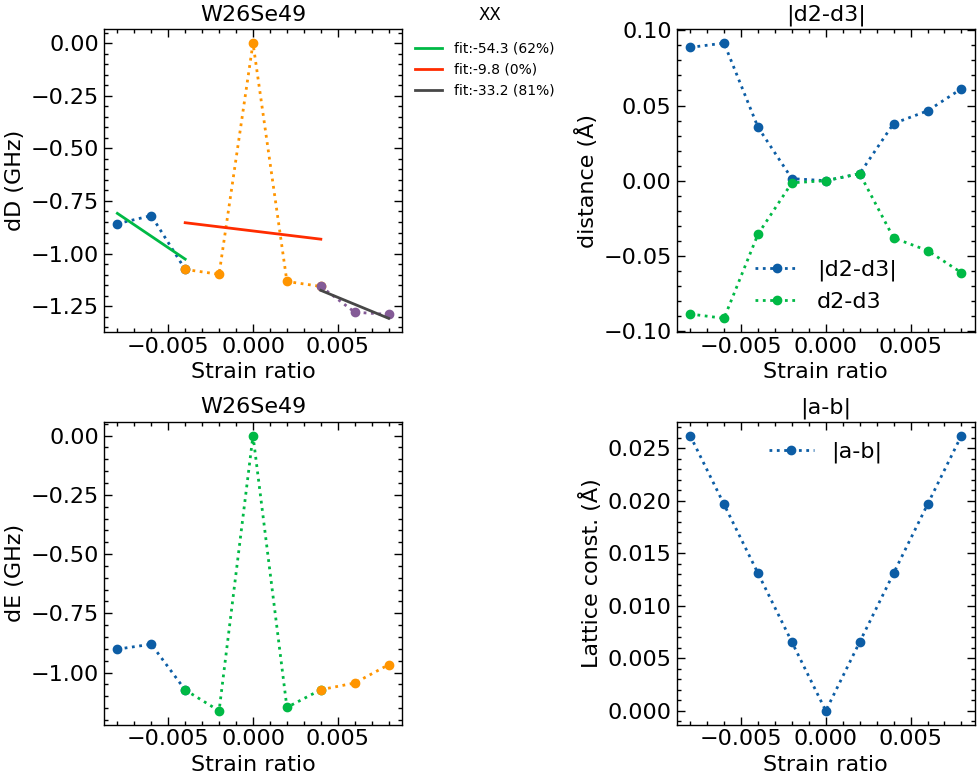

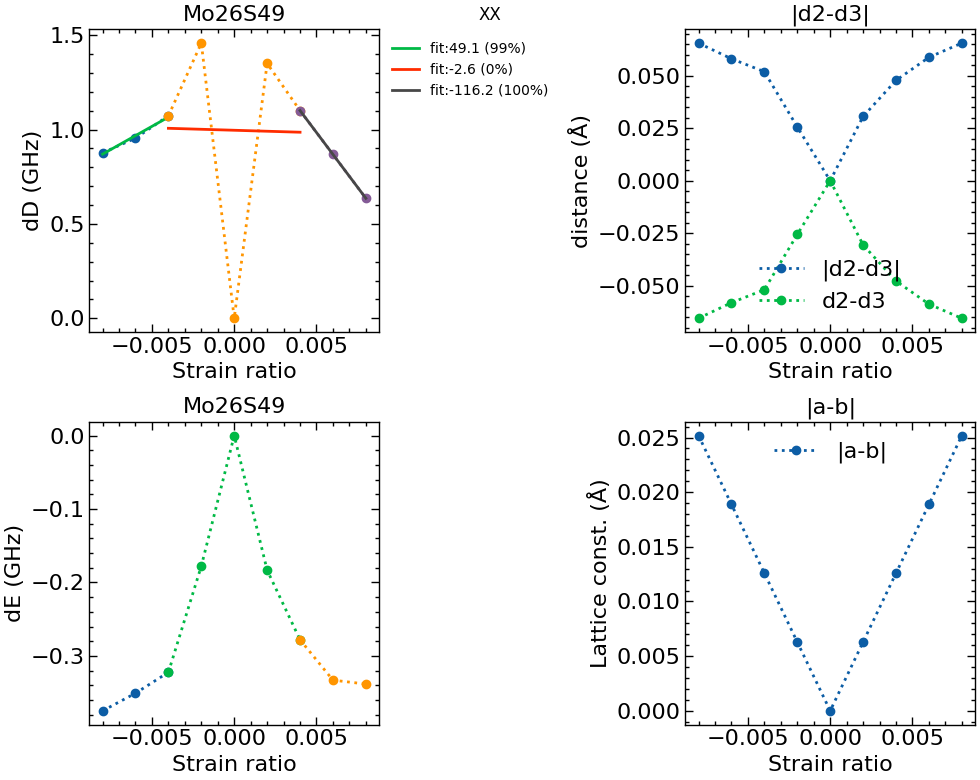

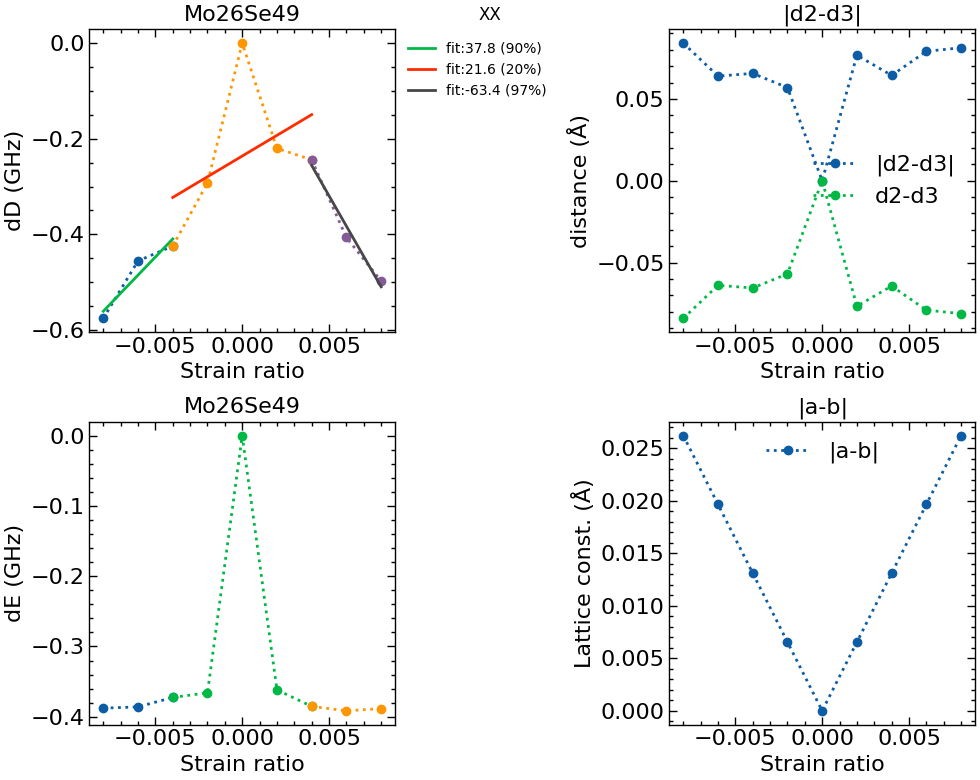

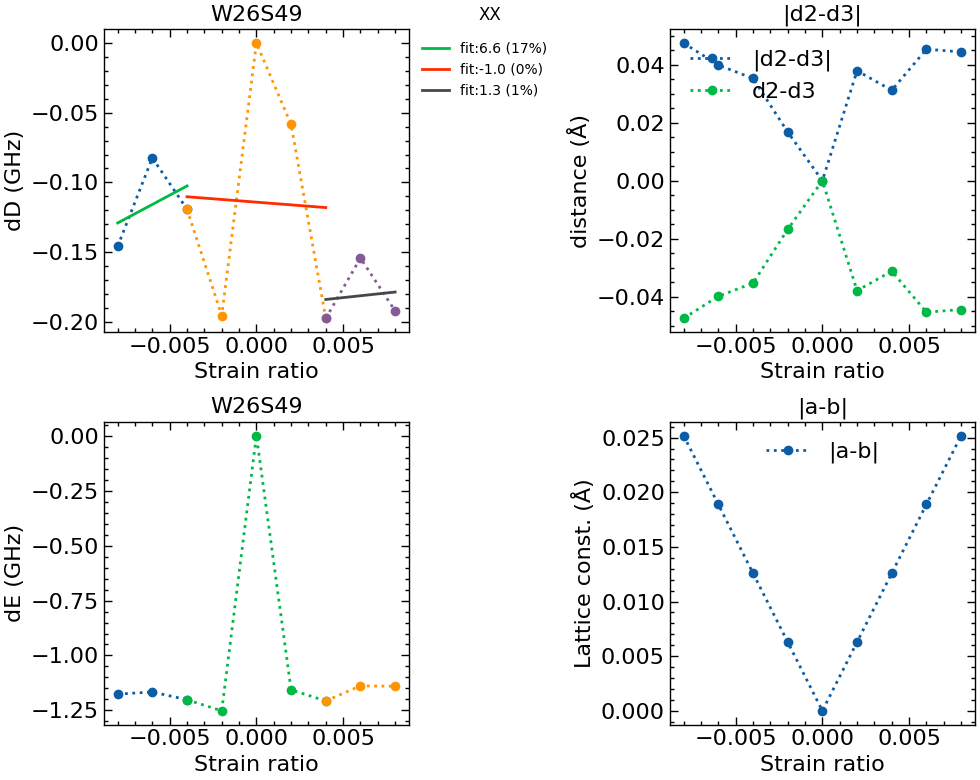

In [124]:
for chem in xx_df.loc[:, "formula"].unique():
    xx_chem_df = xx_df.loc[xx_df.formula==chem]
    fig = plot_D_structure(xx_chem_df, xrange_setting={"xrange_list": [(-0.008, -0.004), (-0.004, 0.004), (0.004, 0.008),]})
    #add fig title
    fig.suptitle("XX")
    fig.show()

zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Ds: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


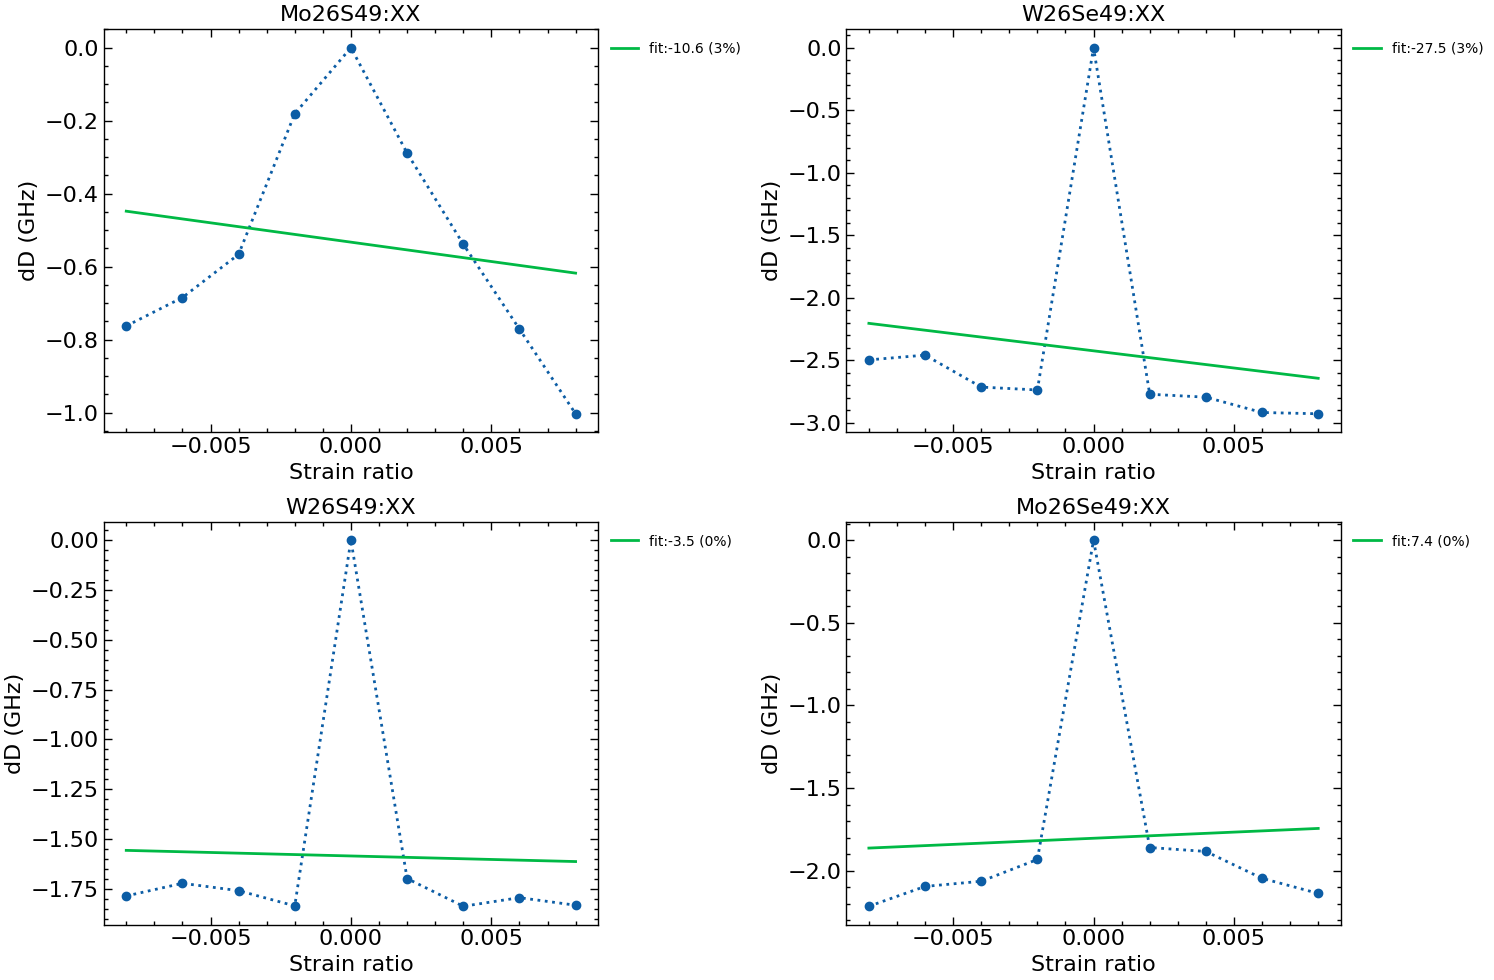

In [184]:
# plot dD vs strain ratio for each chem
# make a figure more wide than high
fig = plt.figure(figsize=(15, 10))
for idx, chem in enumerate(xx_df.loc[:, "formula"].unique()):
    xx_chem_df = xx_df.loc[xx_df.formula==chem]
    ax = fig.add_subplot(2, 2, idx+1)
    for idx, x_range in enumerate([(-0.008, 0.008),]):
        zfs = xx_chem_df.loc[(xx_chem_df["strain_ratio"]>=x_range[0]) & (xx_chem_df["strain_ratio"]<=x_range[1])]
        # fit with linear function and plot
        strain_ratios = np.linspace(x_range[0], x_range[1], 100)
        Ds = zfs["dD"].values
        print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Ds: {len(Ds)}, xrange: {x_range}, strain_ratios: "
              f"{zfs.strain_ratio.values}")
        D_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Ds, 1))
        r2 = r2_score(zfs["dD"], D_fit(zfs["strain_ratio"]))
        slope = D_fit.coeffs[0].__round__(1)
        ax.plot(zfs["strain_ratio"], zfs["dD"], "o:")
        ax.plot(strain_ratios, D_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
        ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        ax.set_ylabel("dD (GHz)")
        ax.set_xlabel("Strain ratio")
        ax.set_title(chem+":XX")

        # set y lim from -2 to 2
        # ax.set_ylim(-2, 2)

fig.tight_layout()
fig.show()


zfs_strain_ratio: 9, Es: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Es: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Es: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]
zfs_strain_ratio: 9, Es: 9, xrange: (-0.008, 0.008), strain_ratios: [-0.008 -0.006 -0.004 -0.002  0.     0.002  0.004  0.006  0.008]


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


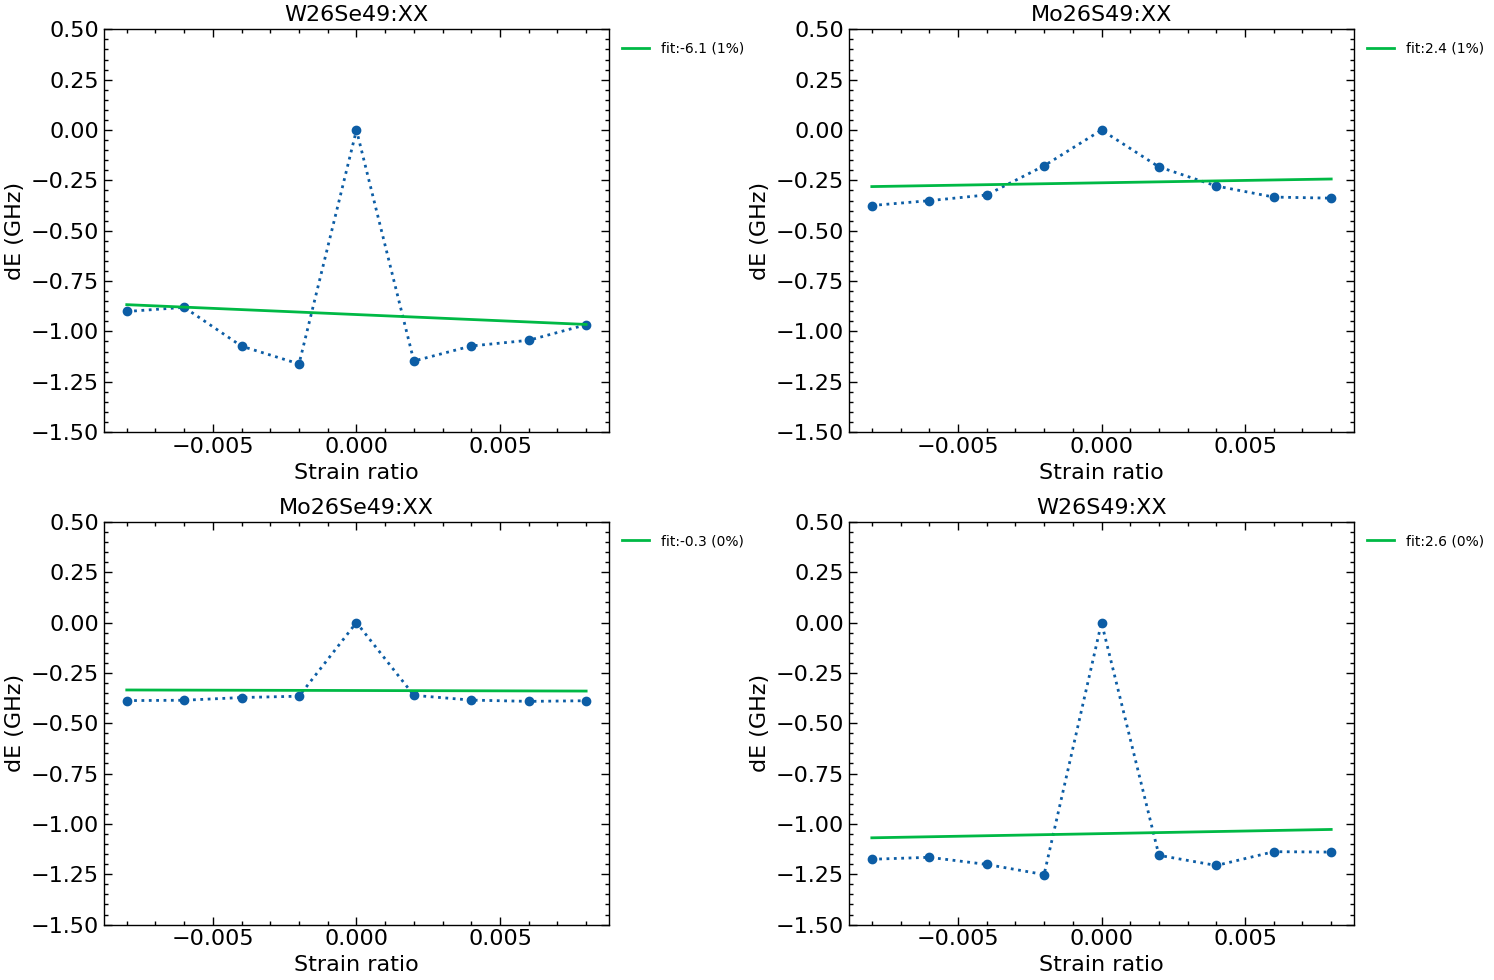

In [155]:
# plot dE vs strain ratio for each chem
# make a figure more wide than high
fig = plt.figure(figsize=(15, 10))
for idx, chem in enumerate(xx_df.loc[:, "formula"].unique()):
    xx_chem_df = xx_df.loc[xx_df.formula==chem]
    ax = fig.add_subplot(2, 2, idx+1)
    for idx, x_range in enumerate([(-0.008, 0.008),]):
        zfs = xx_chem_df.loc[(xx_chem_df["strain_ratio"]>=x_range[0]) & (xx_chem_df["strain_ratio"]<=x_range[1])]
        # fit with linear function and plot
        strain_ratios = np.linspace(x_range[0], x_range[1], 100)
        Es = zfs["dE"].values
        print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Es: {len(Es)}, xrange: {x_range}, strain_ratios: "
              f"{zfs.strain_ratio.values}")
        E_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Es, 1))
        r2 = r2_score(zfs["dE"], E_fit(zfs["strain_ratio"]))
        slope = E_fit.coeffs[0].__round__(1)
        ax.plot(zfs["strain_ratio"], zfs["dE"], "o:")
        ax.plot(strain_ratios, E_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
        ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        ax.set_ylabel("dE (GHz)")
        ax.set_xlabel("Strain ratio")
        ax.set_title(chem+":XX")

        # set y lim from -1.5 to 0.5
        ax.set_ylim(-1.5, 0.5)



fig.tight_layout()
fig.show()


# Check defect states

In [198]:
from qubitPack.qc_searching.analysis.main import *

def get_defect_state_without_ir(defect_taskid):
    defect_db = get_db("qubit_sensor", "tri_strained", port=27017, user="Jeng_ro")
    defect = defect_db.collection.find_one({"task_id": defect_taskid})

    level_info, levels, defect_levels, bulk_tot, bandedge_bulk_tot = _, _, _, _, _
    state = get_defect_state_v3(
        defect_db,
        {"task_id": defect_taskid},
        -10, 10,
        None,
        "all",
        None,
        None,  #(host_db, host_taskid, 0, vbm_dx, cbm_dx),
        0.2,  #0.2
        locpot_c2db=None,  #(c2db, c2db_uid, 0)
        is_vacuum_aligment_on_plot=True,
        edge_tol=(1.5, 1.5), # defect state will be picked only if it's above vbm by 0.025 eV and below
        # cbm by 0.025 eV
        ir_db=None
    )
    tot, proj, d_df, levels, in_gap_levels, bulk_tot, bandedge_bulk_tot = state
    level_info = d_df.to_dict("records")[0]
    plt.show()
    return tot, proj, d_df, levels, in_gap_levels, bulk_tot, bandedge_bulk_tot


In [217]:
xx_yy_df.loc[xx_yy_df.formula=="W26Se49"]

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,scf_taskid,d1,d2,...,z3,z4,a,b,c,NN,spg,structure,dD,dE
12,467,W26Se49,6.925987,-0.000370,-0.008,xx_yy,qubit_sensor.tri_strained,440,2.616866,2.616856,...,1.885018,3.622198,3.249253,3.249253,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05268665 0.03041865 11.55827578] W, [14....",-1.483787,0.000009
16,468,W26Se49,6.839421,-0.000708,-0.006,xx_yy,qubit_sensor.tri_strained,439,2.616649,2.616640,...,1.881731,3.616836,3.255804,3.255804,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05328124 0.03076194 11.56063018] W, [14....",-1.570354,-0.000329
27,465,W26Se49,6.806896,-0.001079,-0.004,xx_yy,qubit_sensor.tri_strained,438,2.615931,2.615931,...,1.876859,3.608817,3.262355,3.262355,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05307853 0.03065431 11.56207546] W, [14....",-1.602878,-0.000700
32,466,W26Se49,6.903577,-0.000441,-0.002,xx_yy,qubit_sensor.tri_strained,442,2.614937,2.614917,...,1.871801,3.602570,3.268906,3.268906,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05311973 0.03065925 11.56077005] W, [14....",-1.506198,-0.000062
40,360,W26Se49,6.770499,-0.000285,0.000,pristine,qubit_sensor.tri_strained,286,2.614874,2.614864,...,1.868164,3.596742,3.275457,3.275457,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05323437 0.03073488 11.56391703] W, [14....",0.000000,0.000000
42,463,W26Se49,6.641545,-0.000261,0.002,xx_yy,qubit_sensor.tri_strained,441,2.614945,2.614925,...,1.862546,3.585716,3.282008,3.282008,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05148651 0.02971627 11.56613157] W, [14....",-1.768230,0.000117
53,479,W26Se49,6.618493,-0.000480,0.004,xx_yy,qubit_sensor.tri_strained,478,2.613814,2.613804,...,1.859422,3.583315,3.288559,3.288559,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05339798 0.03082934 11.56685421] W, [14....",-1.791282,-0.000101
58,464,W26Se49,6.700637,-0.000555,0.006,xx_yy,qubit_sensor.tri_strained,444,2.614919,2.614919,...,1.855856,3.576508,3.295110,3.295110,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05217807 0.03013453 11.56778665] W, [14....",-1.709138,-0.000176
67,476,W26Se49,6.687926,-0.000676,0.008,xx_yy,qubit_sensor.tri_strained,443,2.612494,2.612474,...,1.849958,3.569795,3.301661,3.301660,23.310965,"[5, 6, 0, 25]",P3m1,"[[ 0.05333008 0.0307806 11.57135323] W, [14....",-1.721849,-0.000298


/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/atomate/atomate/utils/database.py:51: DeprecationWarning:

count is deprecated. Use Collection.count_documents instead.



---task_id: 286---

Read vacuum locpot from defect entry (Perturbed bandedges provided):3.173

total_mag:2.000
cbm:10.000, vbm:-10.000, efermi:-2.238
perturbed band edges: (VBM, CBM): (-2.653/[325], -0.0774/[331])
perturbed bandgap: 2.5756
D==D==D==D==D==D==D==D==D==D==D==D==D==D==D==D==D==D==D==D==

Defect levels all range:
            energy  occupied  tot_proj  adj_proj  antisite_proj  n_occ_e spin
band_index                                                                   
398         1.8279     False    0.3585    100.00           0.00      0.0    1
374         1.0702     False    0.2270     96.43           3.57      0.0    1
373         1.0702     False    0.2272     96.43           3.57      0.0    1
330        -0.5937     False    0.4086      5.48          94.52      0.0    1
329        -1.7396      True    0.5008     12.30          87.70      1.0    1
328        -1.7397      True    0.5008     12.30          87.70      1.0    1
327        -2.5541      True    0.2017     72.09 

TypeError: __init__() missing 4 required positional arguments: 'sigma', 'vacuum_level', 'mark_vbm_cbm', and 'mark_efermi'

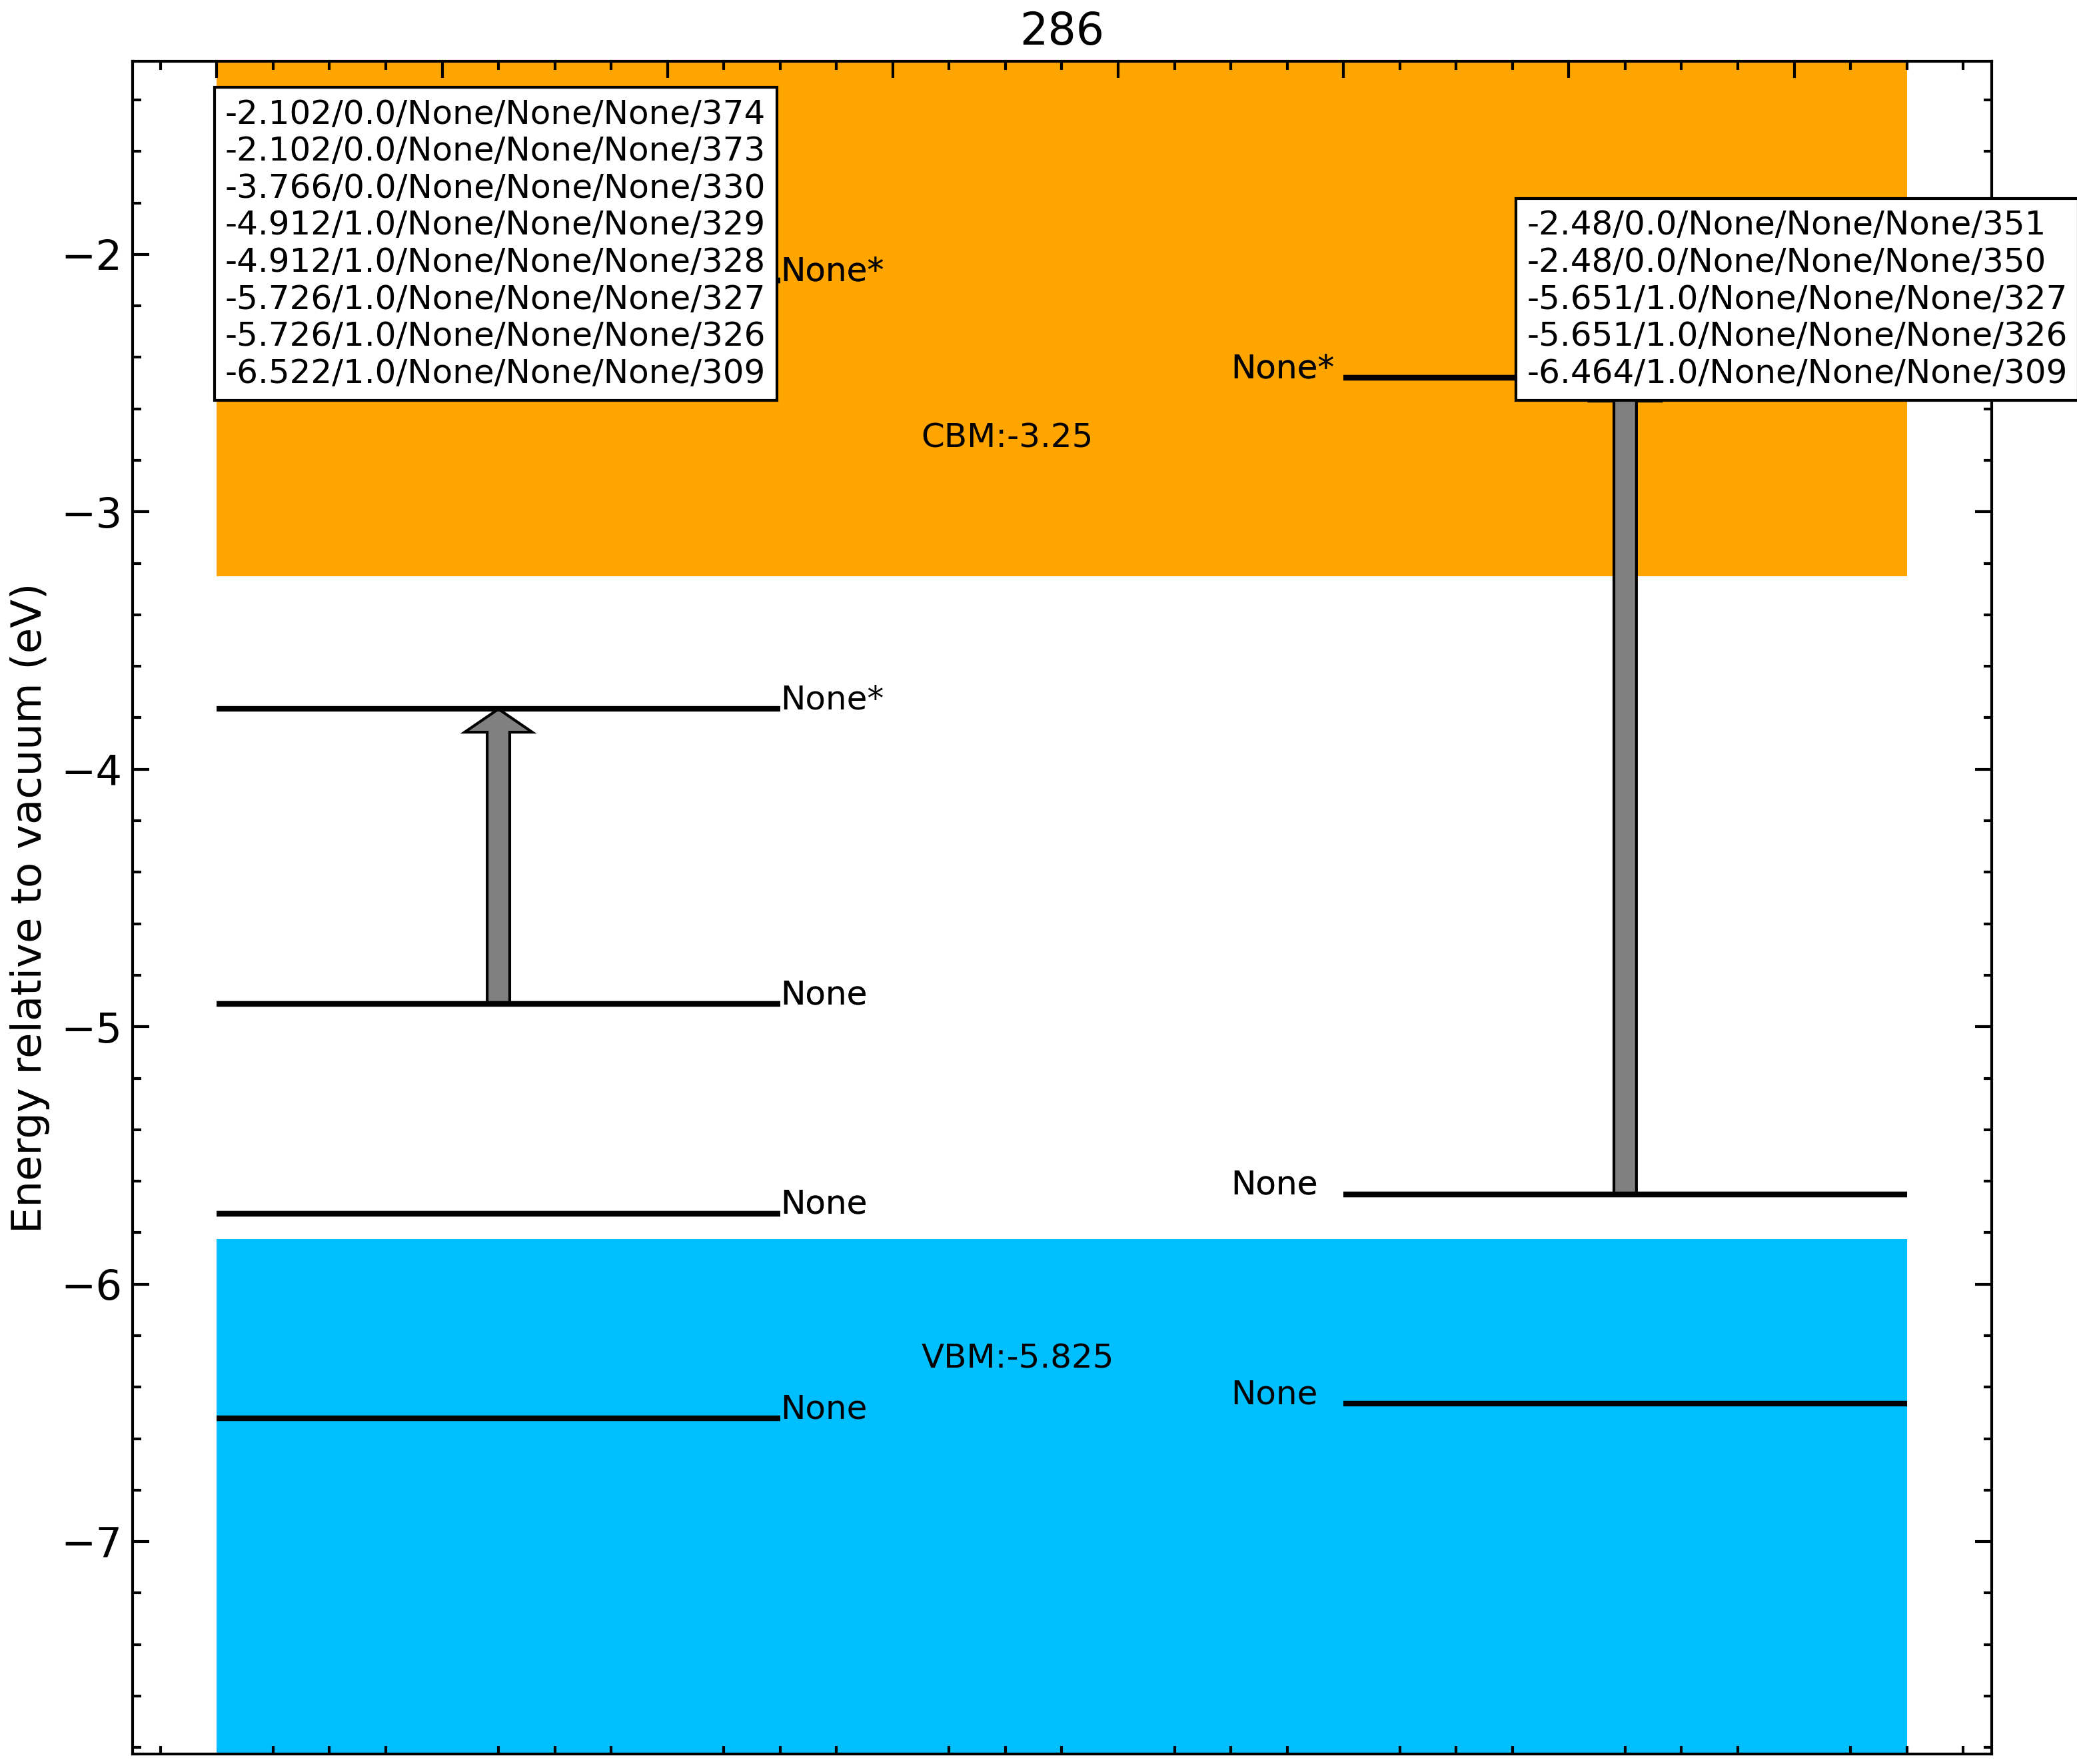

In [221]:
get_defect_state_without_ir(286

# Correlation between D and local geometry

## XX-YY

In [303]:
# create a new df which contains mean and std of D, E, d1, d2, d3, a, b, and c for each chem
xx_yy_mean_std_df = pd.DataFrame(columns=["formula", "D_mean", "D_std", "E_mean", "E_std", "d1_mean", "d1_std",
                                          "d2_mean", "d2_std", "d3_mean", "d3_std", "a_mean", "a_std", "b_mean",
                                          "b_std", "c_mean", "c_std"])
for chem in xx_yy_df.formula.unique():
    chem_df = xx_yy_df.loc[xx_yy_df.formula==chem]
    xx_yy_mean_std_df = xx_yy_mean_std_df.append({"formula": chem,
                                                  "D_mean": chem_df["D"].mean(),
                                                  "D_std": chem_df["D"].std(),
                                                  "E_mean": chem_df["E"].mean(),
                                                  "E_std": chem_df["E"].std(),
                                                  "d1_mean": chem_df["d1"].mean(),
                                                  "d1_std": chem_df["d1"].std(),
                                                  "d2_mean": chem_df["d2"].mean(),
                                                  "d2_std": chem_df["d2"].std(),
                                                  "d3_mean": chem_df["d3"].mean(),
                                                  "d3_std": chem_df["d3"].std(),
                                                  "a_mean": chem_df["a"].mean(),
                                                  "a_std": chem_df["a"].std(),
                                                  "b_mean": chem_df["b"].mean(),
                                                  "b_std": chem_df["b"].std(),
                                                  "c_mean": chem_df["c"].mean(),
                                                  "c_std": chem_df["c"].std(),
                                                  }, ignore_index=True)
xx_yy_mean_std_df = xx_yy_mean_std_df.sort_values(by="formula")

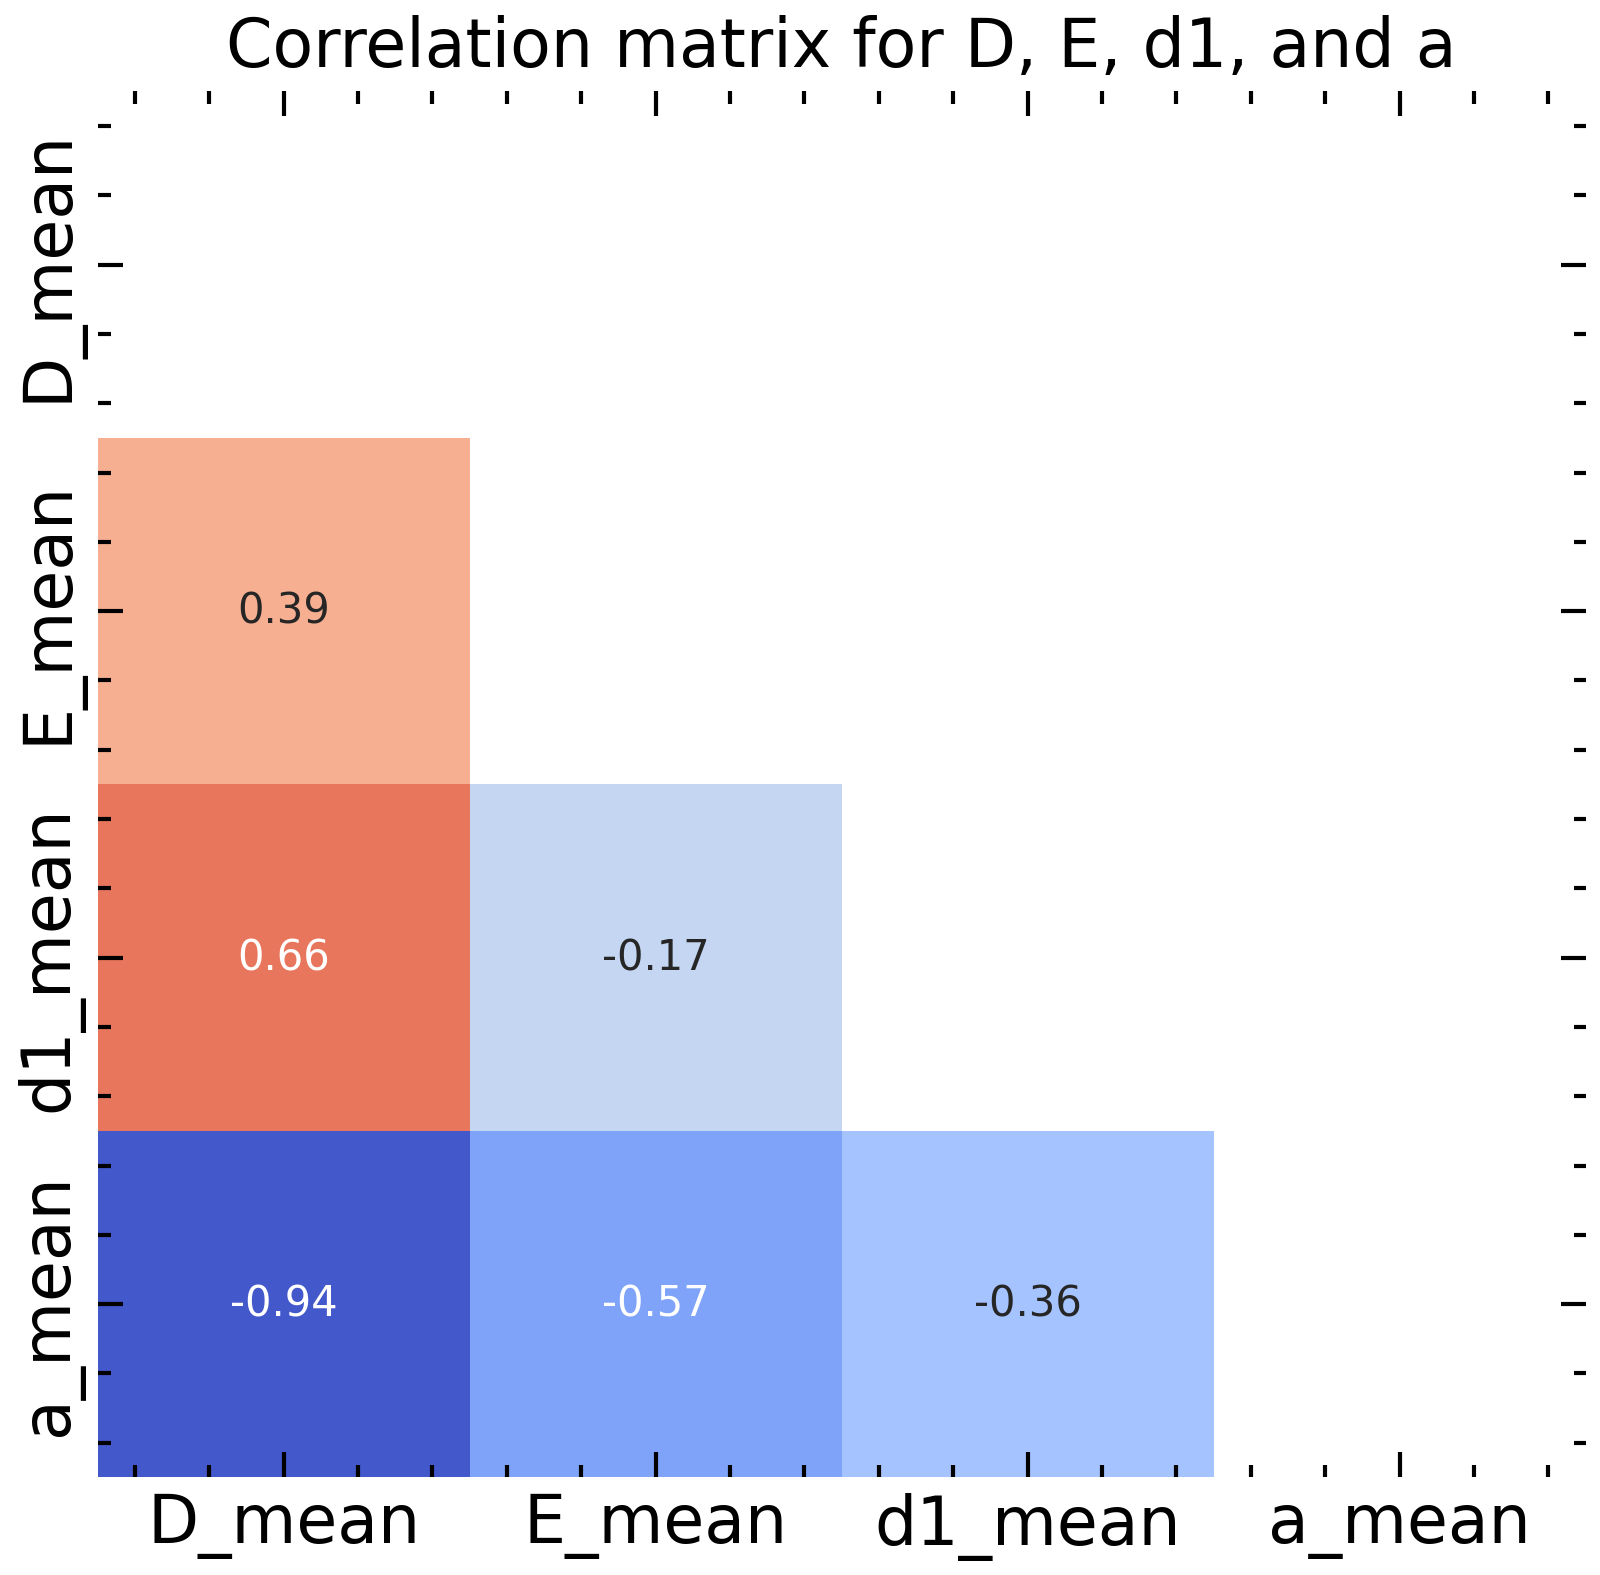

In [379]:
# get correlation matrix for D_mean, d1_mean, and a_mean.
xx_yy_mean_std_corr = xx_yy_mean_std_df.loc[:, ["D_mean", "E_mean", "d1_mean", "a_mean"]].corr()
# get heatmap and show only upper triangle
import seaborn as sns
sns.heatmap(xx_yy_mean_std_corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm", mask=np.triu(xx_yy_mean_std_corr))
# remove color bar
plt.gcf().axes[-1].remove()
# add title
plt.title("Correlation matrix for D, E, d1, and a")
# increase resolution and copy to clipboard
plt.gcf().set_dpi(300)

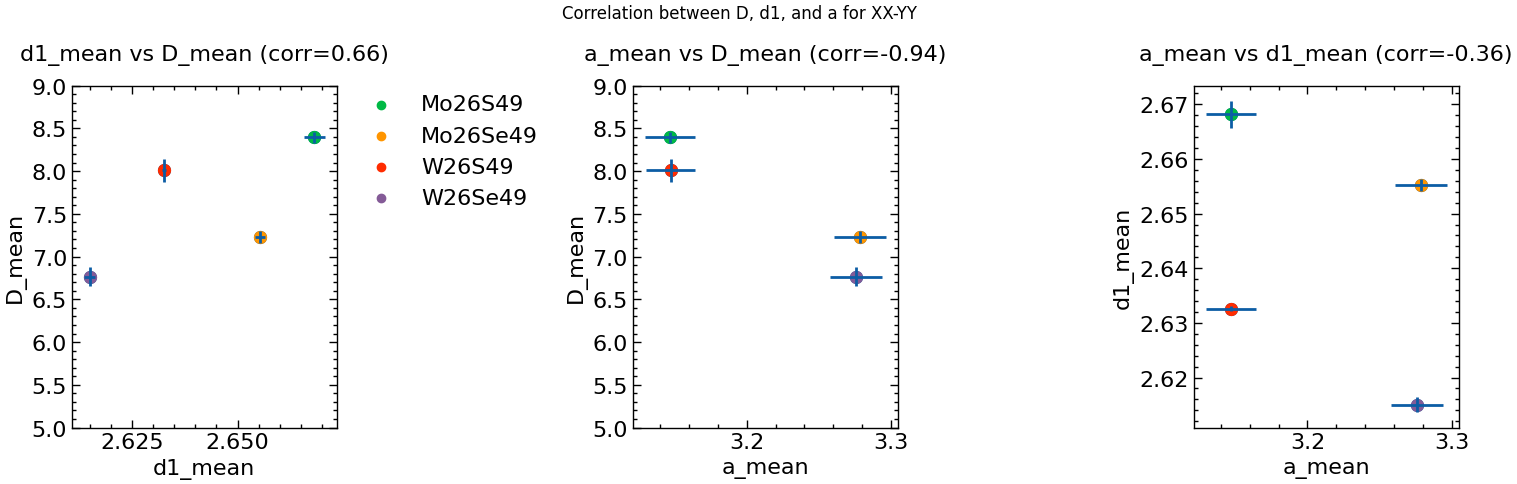

In [384]:
# plot 3 subplots for D_mean vs d1_mean, D_mean vs a_mean, and d1_mean vs a_mean. Add error bar for each point. Add legend by formula.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (x, y) in enumerate([("d1_mean", "D_mean"), ("a_mean", "D_mean"), ("a_mean", "d1_mean")]):
    axs[i].scatter(xx_yy_mean_std_df[x], xx_yy_mean_std_df[y])
    # color by formula
    for chem in xx_yy_mean_std_df.formula.unique():
        chem_df = xx_yy_mean_std_df.loc[xx_yy_mean_std_df.formula==chem]
        axs[i].scatter(chem_df[x], chem_df[y], label=chem)

    axs[i].errorbar(xx_yy_mean_std_df[x], xx_yy_mean_std_df[y], xerr=xx_yy_mean_std_df[x.replace("mean", "std")],
                    yerr=xx_yy_mean_std_df[y.replace("mean", "std")], fmt="none")

    axs[i].set_xlabel(x)
    axs[i].set_ylabel(y)
    # show legend for the first subplot only and move it to the right outside the plot
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # add correlation coefficient to the subplot title
    corr = xx_yy_mean_std_corr.loc[x, y]
    # move up the title a little bit
    axs[i].set_title(f"{x} vs {y} (corr={corr:.2f})", y=1.05)

    # increase the size of data points by 2
    for item in axs[i].get_children():
        from matplotlib.collections import PathCollection
        if isinstance(item, PathCollection):
            item.set_sizes([item.get_sizes()[0]*2])

    # set D_mean range from 5 to 9
    if y == "D_mean":
        axs[i].set_ylim(5, 9)
        # set main y ticks to 0.5
        from matplotlib.ticker import MultipleLocator
        axs[i].yaxis.set_major_locator(MultipleLocator(0.5))
    #


# add title for the whole figure
fig.suptitle("Correlation between D, d1, and a for XX-YY")
plt.tight_layout()


## XX

In [308]:
# create a new df which contains mean and std of D, E, d1, d2, d3, a, b, and c for each chem
xx_mean_std_df = pd.DataFrame(columns=["formula", "D_mean", "D_std", "E_mean", "E_std", "d1_mean", "d1_std",
                                          "d2_mean", "d2_std", "d3_mean", "d3_std", "a_mean", "a_std", "b_mean",
                                          "b_std", "c_mean", "c_std"])
for chem in xx_df.formula.unique():
    chem_df = xx_df.loc[xx_df.formula==chem]
    xx_mean_std_df = xx_mean_std_df.append({"formula": chem,
                                                  "D_mean": chem_df["D"].mean(),
                                                  "D_std": chem_df["D"].std(),
                                                  "E_mean": chem_df["E"].mean(),
                                                  "E_std": chem_df["E"].std(),
                                                  "d1_mean": chem_df["d1"].mean(),
                                                  "d1_std": chem_df["d1"].std(),
                                                  "d2_mean": chem_df["d2"].mean(),
                                                  "d2_std": chem_df["d2"].std(),
                                                  "d3_mean": chem_df["d3"].mean(),
                                                  "d3_std": chem_df["d3"].std(),
                                                  "a_mean": chem_df["a"].mean(),
                                                  "a_std": chem_df["a"].std(),
                                                  "b_mean": chem_df["b"].mean(),
                                                  "b_std": chem_df["b"].std(),
                                                  "c_mean": chem_df["c"].mean(),
                                                  "c_std": chem_df["c"].std(),
                                                  }, ignore_index=True)
xx_mean_std_df = xx_mean_std_df.sort_values(by="formula")

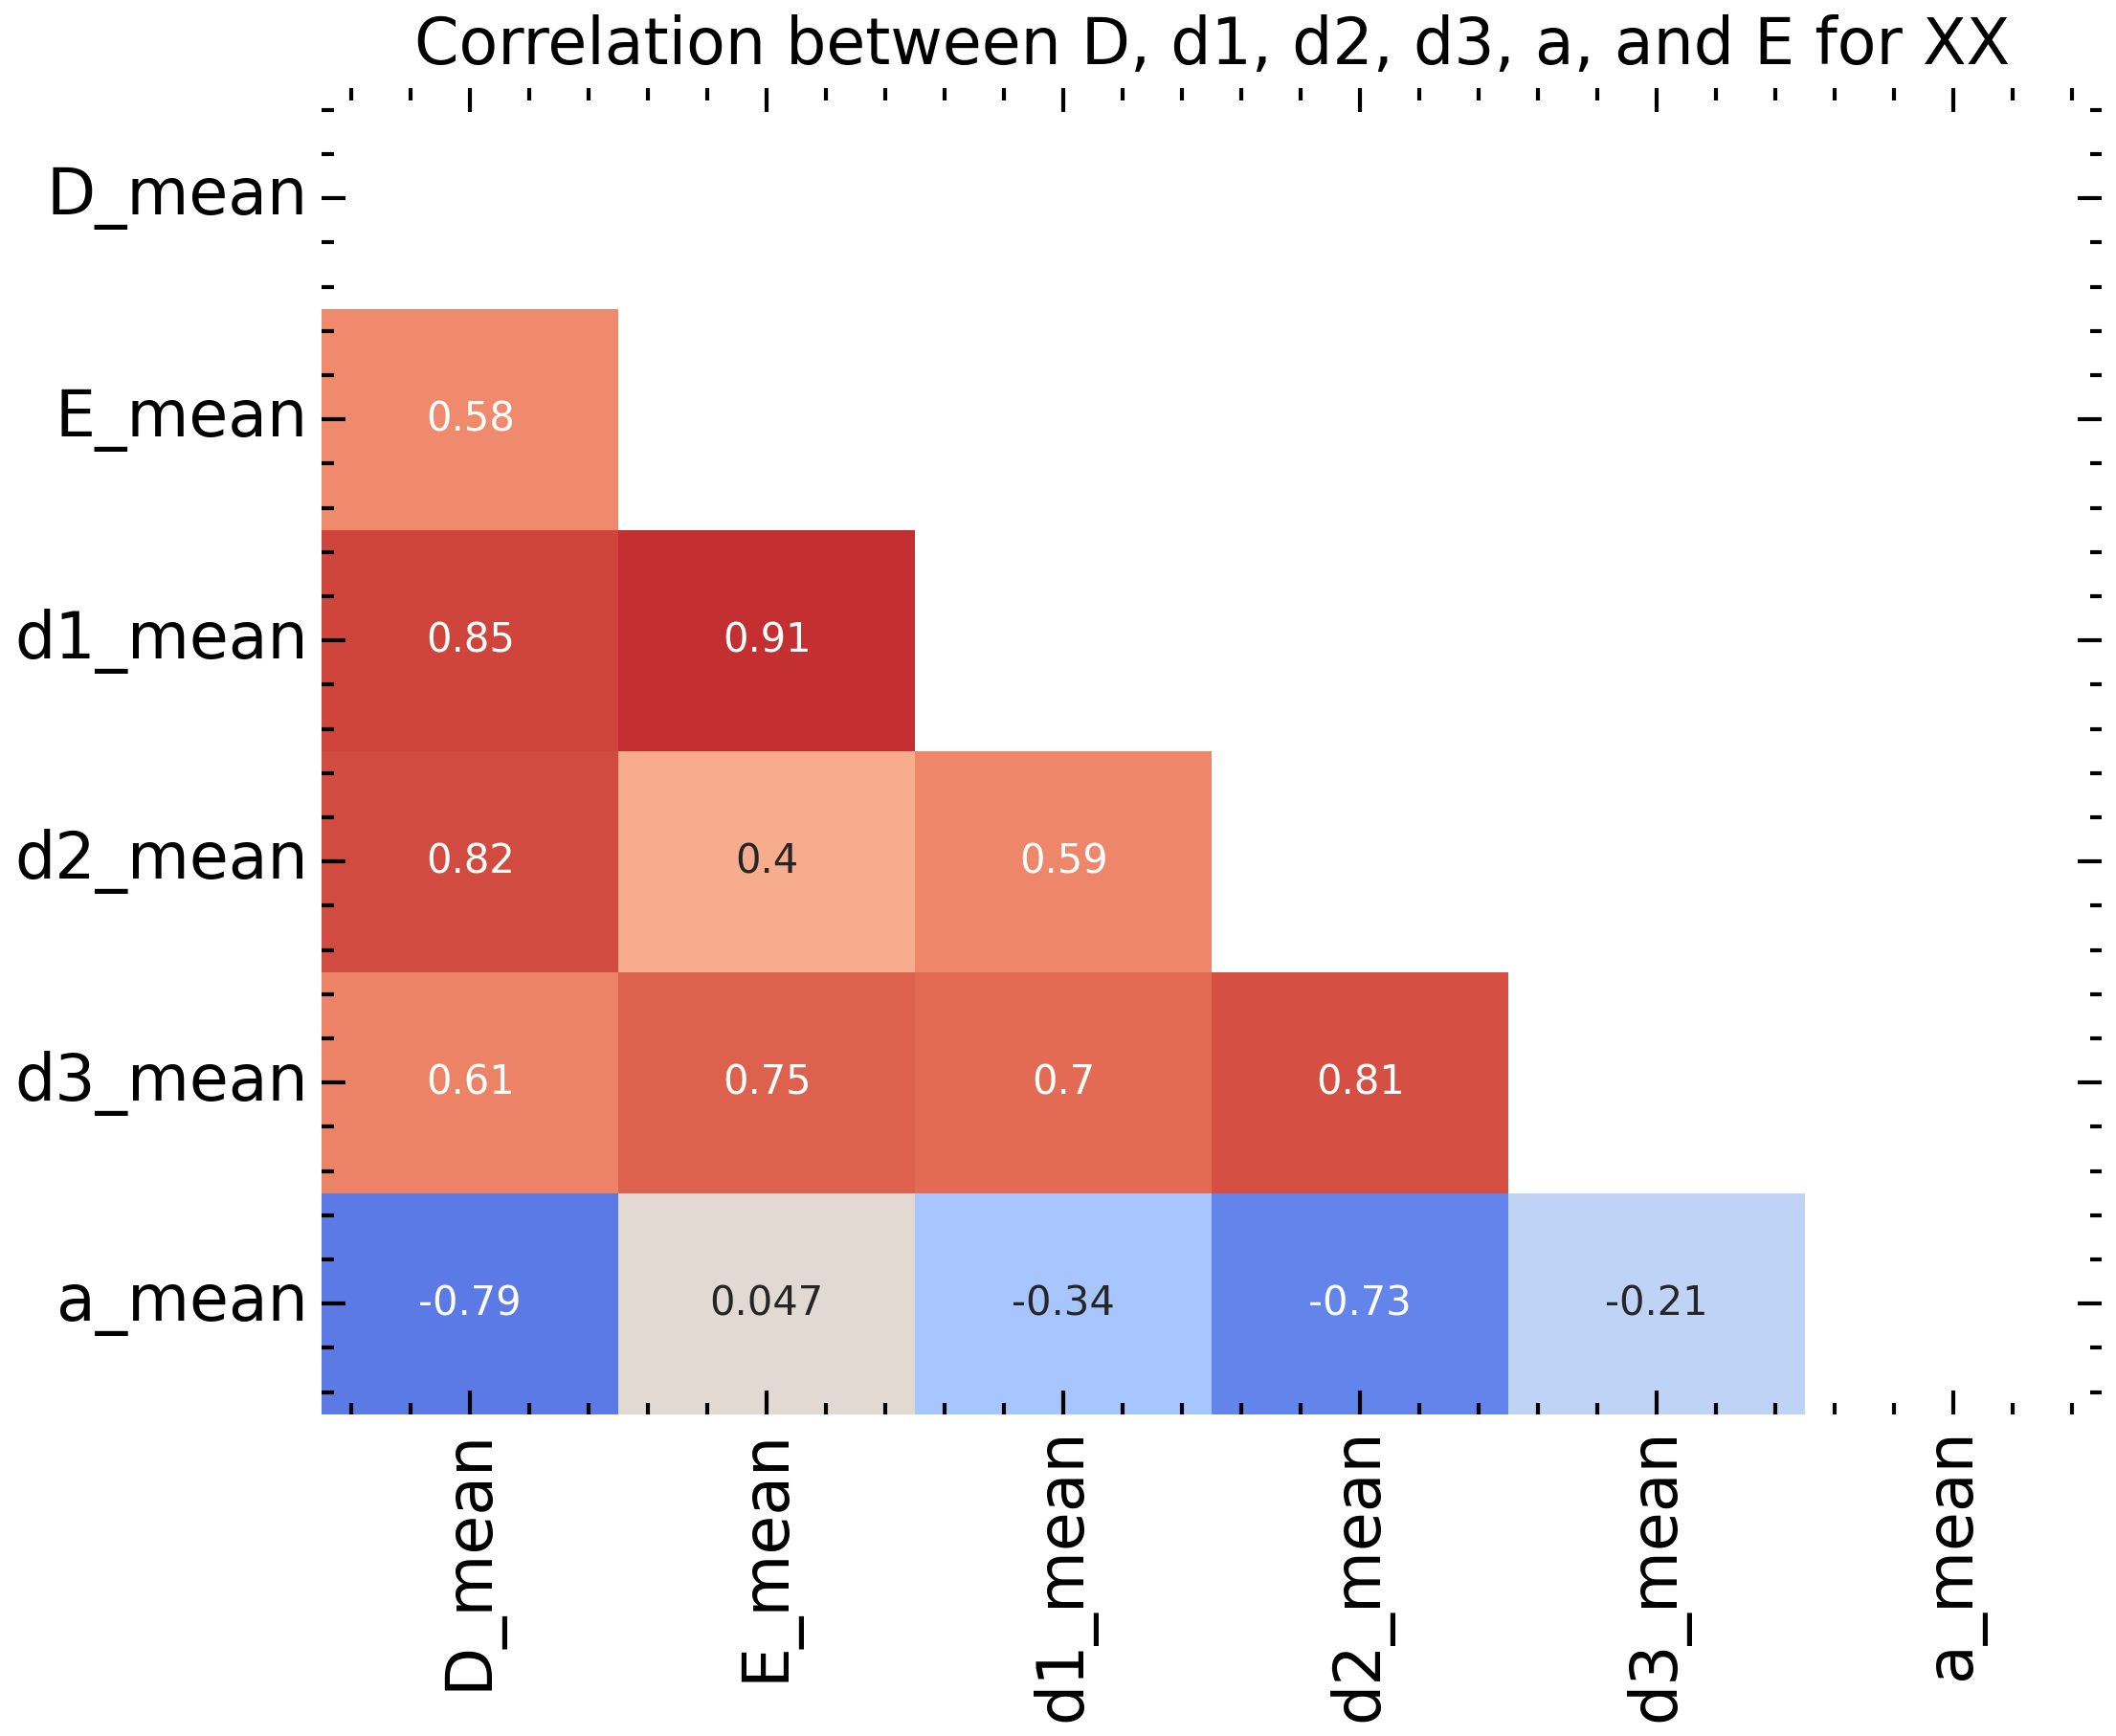

In [377]:
# get correlation matrix for D_mean, d1_mean, d2_mean, d3_mean, and a_mean.
xx_mean_std_corr = xx_mean_std_df.loc[:, ["D_mean", "E_mean", "d1_mean", "d2_mean", "d3_mean", "a_mean"]].corr()
# get heatmap and show only the upper triangle
import seaborn as sns
sns.heatmap(xx_mean_std_corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm", mask=np.triu(xx_mean_std_corr))

# remove color bar
plt.gca().collections[0].colorbar.remove()
# increase resolution and copy to clipboard
# add title
plt.title("Correlation between D, d1, d2, d3, a, and E for XX")
plt.gcf().set_dpi(300)


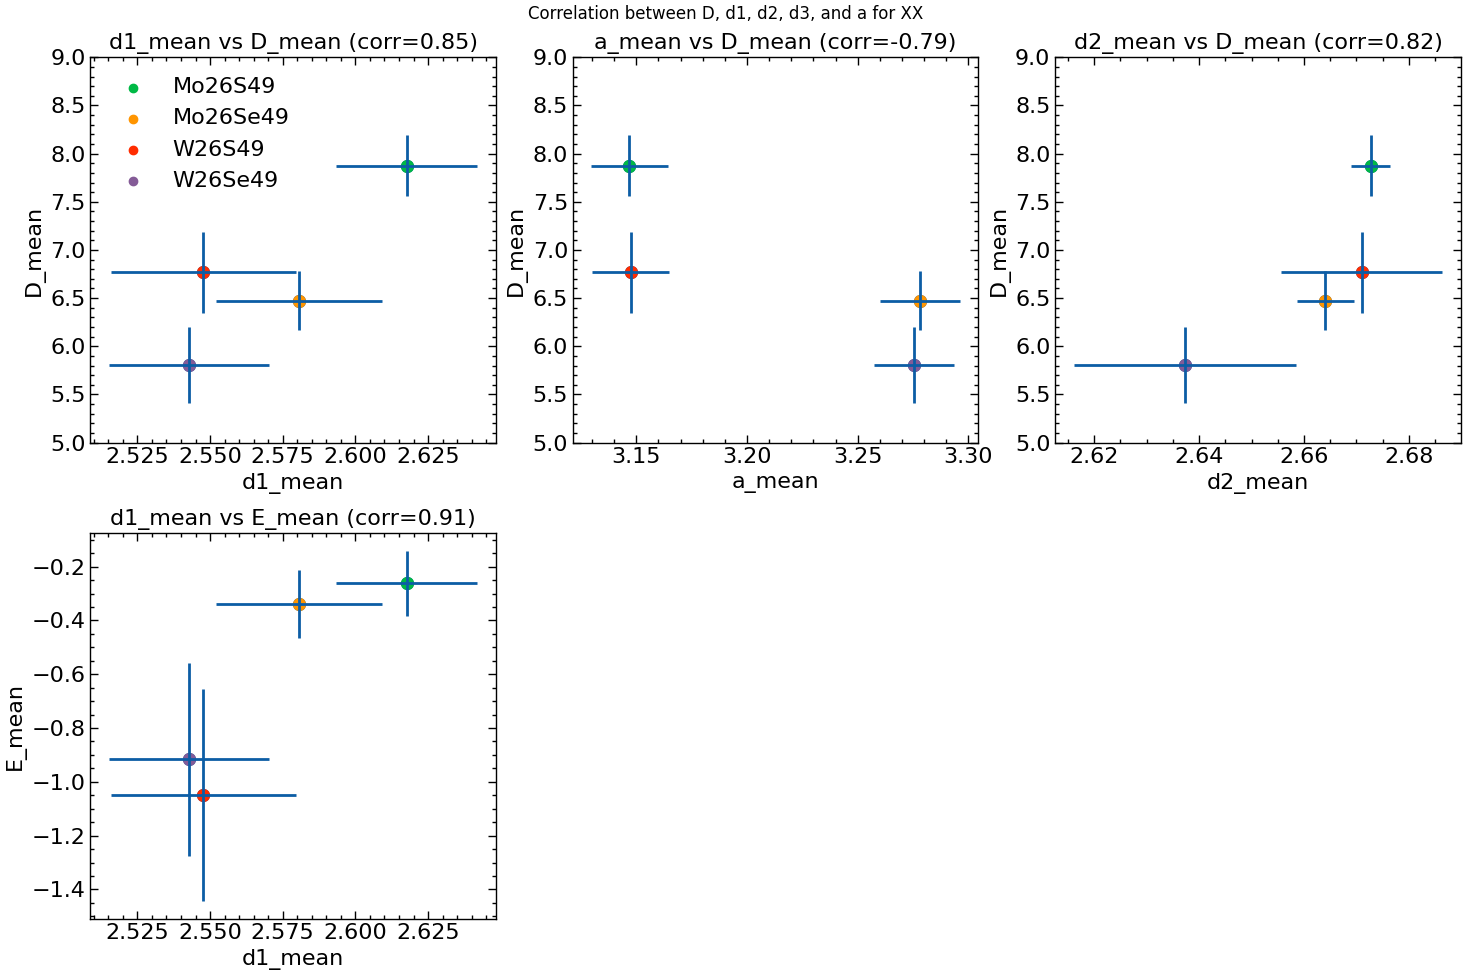

In [375]:
# plot the subplots for d1_mean vs D_mean, a_mean vs D_mean, a_mean vs D_mean , d1_mean vs d3_mean, d2_mean vs d3_mean. Add error bar for each point. Add legend by formula.

fig = plt.figure(figsize=(15, 10))
# for i, (x, y) in enumerate([("d1_mean", "D_mean"), ("a_mean", "D_mean"), ("d2_mean", "D_mean"), ("d1_mean", "E_mean"), ("d1_mean", "d3_mean"), ("d2_mean", "d3_mean")]):
for i, (x, y) in enumerate([("d1_mean", "D_mean"), ("a_mean", "D_mean"), ("d2_mean", "D_mean"), ("d1_mean", "E_mean")]):
    # plot the scatter plot
    axs = fig.add_subplot(2, 3, i+1)
    axs.scatter(xx_mean_std_df[x], xx_mean_std_df[y])
    # add error bar
    axs.errorbar(xx_mean_std_df[x], xx_mean_std_df[y], xerr=xx_mean_std_df[f"{x.split('_')[0]}_std"], yerr=xx_mean_std_df[f"{y.split('_')[0]}_std"], fmt="none")

    # add xlabel
    axs.set_xlabel(x)
    # add ylabel
    axs.set_ylabel(y)

    # color by formula
    for chem in xx_mean_std_df.formula.unique():
        chem_df = xx_mean_std_df.loc[xx_mean_std_df.formula==chem]
        axs.scatter(chem_df[x], chem_df[y], label=chem)

    if i == 0:
        axs.legend()

    # mark coefficient of correlation in the subplot title
    corr = xx_mean_std_df.loc[:, [x, y]].corr().iloc[0, 1]
    axs.set_title(f"{x} vs {y} (corr={corr:.2f})")

    # increase the size of data points by 2
    for item in axs.get_children():
        from matplotlib import collections
        if isinstance(item, collections.PathCollection):
            item.set_sizes([item.get_sizes()[0]*2])


    # set D_mean ranging from 5 to 9
    if y == "D_mean":
        axs.set_ylim(5, 9)

    # add title for the whole figure
fig.suptitle("Correlation between D, d1, d2, d3, and a for XX")
plt.tight_layout()


